#### Andrew Miller <br> Math 189 <br> Final Project: Predicting Housing Prices in Ames, Iowa

In [61]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn
import scipy.stats as stats
from scipy.stats import norm
from sklearn.ensemble import ExtraTreesClassifier
from sklearn import preprocessing
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
#import regressors

In [62]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge, RidgeCV,LassoCV
from sklearn.model_selection import cross_val_score


Lin_Reg = LinearRegression()
Lasso_Reg = Lasso()
LassoCV_Reg = LassoCV(alphas = [ .001*i for i in range(1000)])
RidgeCV_Reg = RidgeCV()
Ridge_Reg = Ridge()
#http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html
#http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoCV.html
#http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html
#http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html
#http://scikit-learn.org/stable/modules/linear_model.html

In [63]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
del train['Id']


## Need a list of categorical features

In [64]:
categorical = ['MSSubClass', 'MSZoning', 'Street','Alley', 
'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
'HouseStyle','OverallQual','OverallCond',
'RoofStyle','RoofMatl','Exterior1st','Exterior2nd','MasVnrType',
'ExterQual','ExterCond','Foundation','BsmtQual','BsmtCond',
'BsmtExposure','BsmtFinType1','BsmtFinType2',
'Heating','HeatingQC','CentralAir','Electrical','KitchenQual',
'Functional','FireplaceQu','GarageType',
'GarageFinish','GarageQual','PavedDrive',
'Fence','MiscFeature','SaleType','SaleCondition']

## Model evaluation uses RMSE of the log of the predicted value and log of the observed value. Using the logs means that errors in predicting expensive houses and cheap houses will affect the result equally.

In [65]:
def NormRMSE(observed, predicted):
    return np.sqrt(((predicted - observed)** 2).mean())
def LogRMSE(observed, predicted):
    return np.sqrt(((np.log(1+predicted) - np.log(1+observed))** 2).mean())

## Cross validation using k-folds for model evaluation

In [66]:
from sklearn.model_selection import KFold

def CV(data,model,k):
    RMSE = []
    #set number of folds
    kf = KFold(n_splits=k, shuffle=True)
    #X=features, y=sale price
    X = data.copy()

    y = X.SalePrice
    del X['SalePrice']

    X = X.values

    #for each fold
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index, :], X[test_index, :]
        y_train, y_test = y[train_index], y[test_index]
        #fit the model
        model.fit(X_train, y_train)
        #predict values
        y_predictions = model.predict(X_test)

        #evaluate using RMSE (we did a log transformation of sale price later on so regular RMSE is correct)
        RMSE.append(NormRMSE(y_test, y_predictions))
    return np.mean(RMSE)

### Lets see how our features relate to eachother

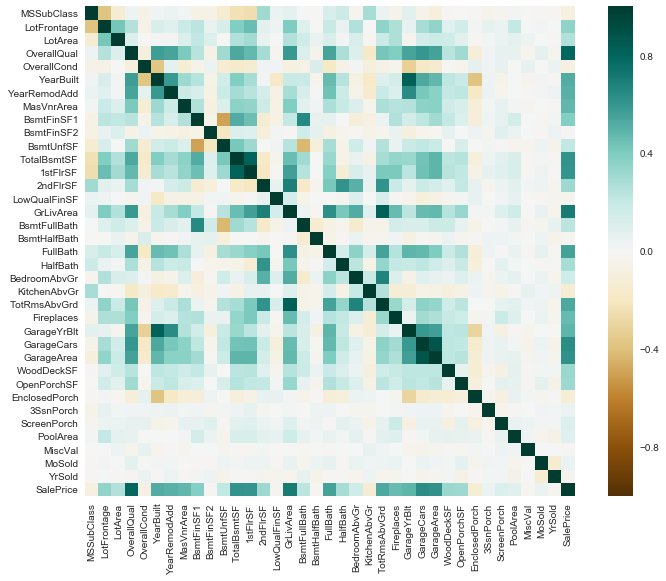

In [8]:
correlation_mx = train.corr()
f, ax = plt.subplots(figsize=(12, 9))

seaborn.heatmap(correlation_mx, vmax=1, square=True,cmap='BrBG');
plt.savefig('Feature_Correlation_No_Values.png', dpi=320)


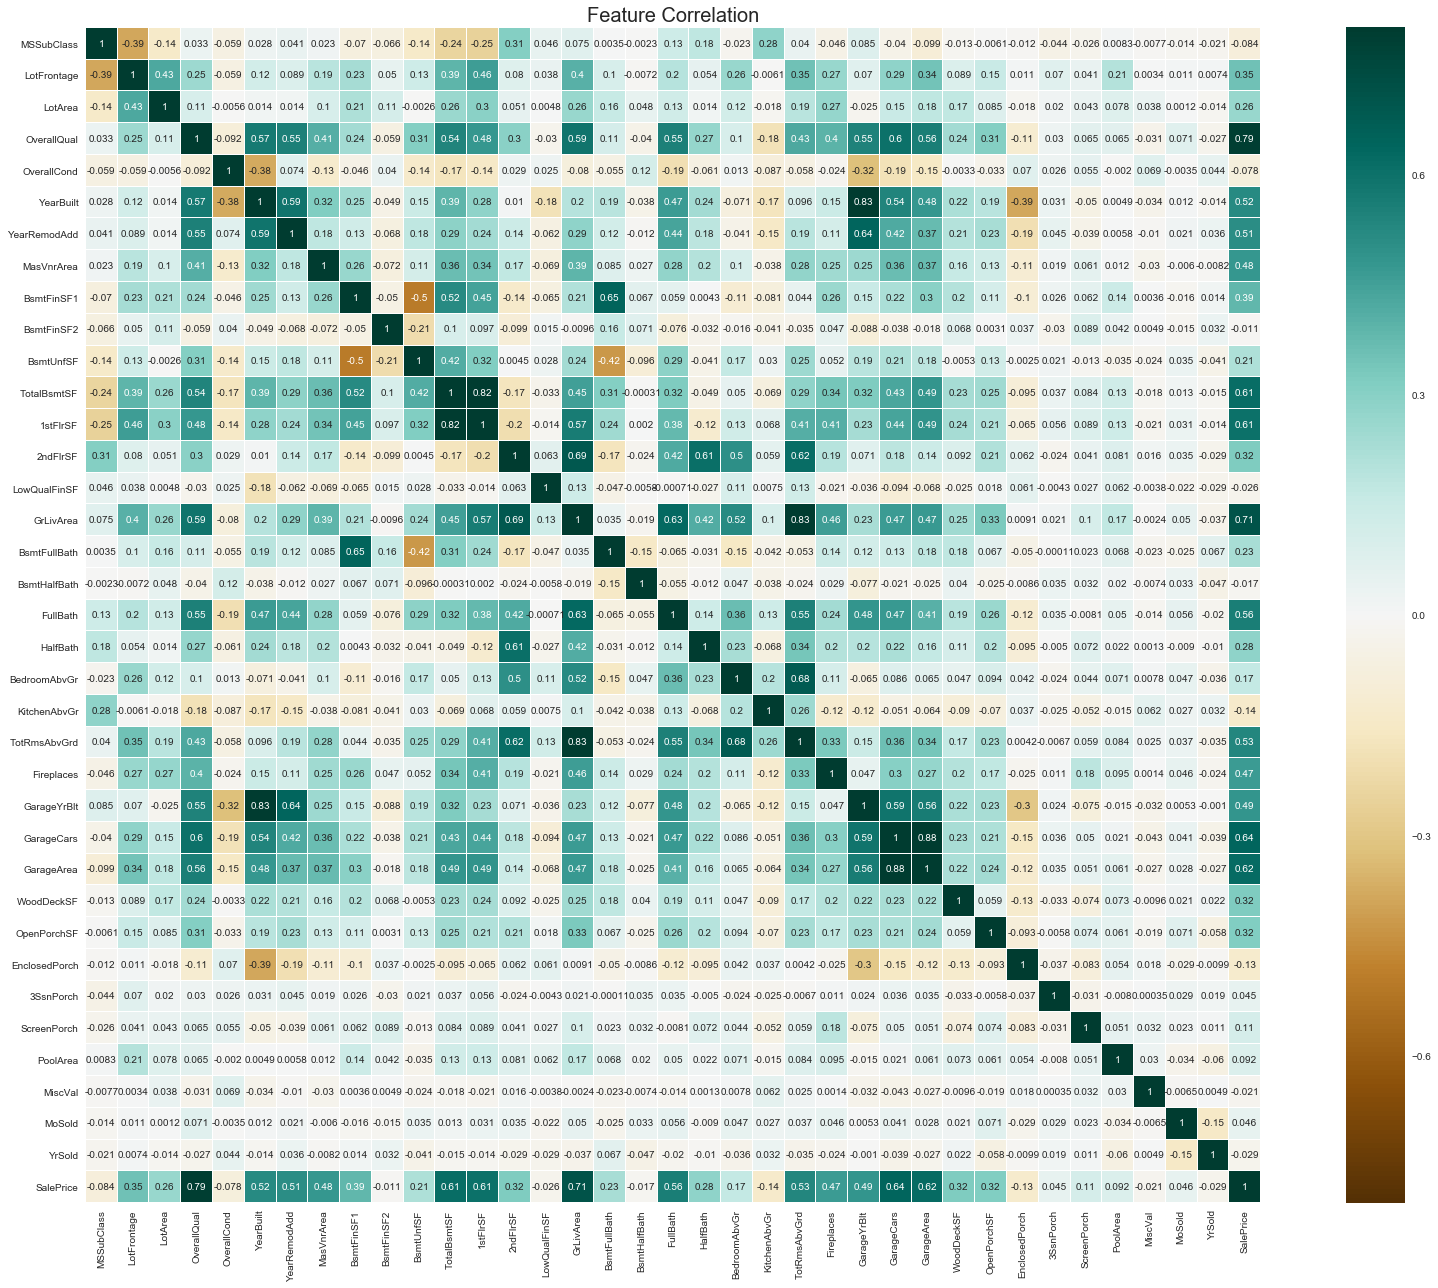

In [9]:
plt.figure(figsize=(24, 18))

seaborn.heatmap(correlation_mx, vmax=.8, linewidths=0.01,cmap='BrBG',
            square=True,annot=True,linecolor="white")
plt.title('Feature Correlation',size=20);
matplotlib.rcParams['font.weight']=('bold')    # bold fonts are easier to see
matplotlib.rcParams['ytick.labelsize']=(16)   # tick labels bigger
matplotlib.rcParams['xtick.labelsize']=(16)   # tick labels bigger
plt.tight_layout()
plt.savefig('Feature_Correlation.png', dpi=320)


## Problem of Multicolinearity (variables correlated to eachother in addition to sale price) making it difficult to interpret models.

In [10]:
sale_correlation = train.corr()["SalePrice"]
sale_correlation[np.argsort(sale_correlation, axis=0)]

KitchenAbvGr    -0.135907
EnclosedPorch   -0.128578
MSSubClass      -0.084284
OverallCond     -0.077856
YrSold          -0.028923
LowQualFinSF    -0.025606
MiscVal         -0.021190
BsmtHalfBath    -0.016844
BsmtFinSF2      -0.011378
3SsnPorch        0.044584
MoSold           0.046432
PoolArea         0.092404
ScreenPorch      0.111447
BedroomAbvGr     0.168213
BsmtUnfSF        0.214479
BsmtFullBath     0.227122
LotArea          0.263843
HalfBath         0.284108
OpenPorchSF      0.315856
2ndFlrSF         0.319334
WoodDeckSF       0.324413
LotFrontage      0.351799
BsmtFinSF1       0.386420
Fireplaces       0.466929
MasVnrArea       0.477493
GarageYrBlt      0.486362
YearRemodAdd     0.507101
YearBuilt        0.522897
TotRmsAbvGrd     0.533723
FullBath         0.560664
1stFlrSF         0.605852
TotalBsmtSF      0.613581
GarageArea       0.623431
GarageCars       0.640409
GrLivArea        0.708624
OverallQual      0.790982
SalePrice        1.000000
Name: SalePrice, dtype: float64

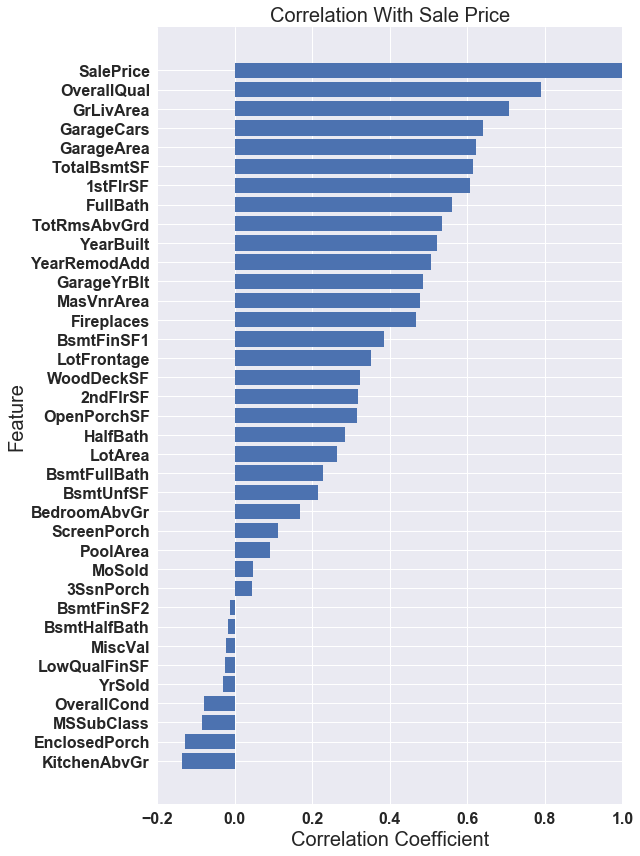

In [11]:
sale_correlation = train.corr()["SalePrice"]

sale_correlation = sale_correlation[np.argsort(sale_correlation, axis=0)]
feature = []
value = []
for i in range(len(sale_correlation)):
    feature.append(sale_correlation.index[i])
    value.append(sale_correlation[i])

y_pos = np.arange(len(feature)) 
plt.barh(y_pos, value, align='center')
plt.xlim([ -.2,1])

plt.yticks(y_pos, feature)
plt.xticks()
plt.xlabel('Correlation Coefficient',size=20)
plt.ylabel("Feature",size=20)
plt.title('Correlation With Sale Price',size=20)
fig = plt.gcf()
fig.set_size_inches(9, 12)
matplotlib.rcParams['font.weight']=('bold')    # bold fonts are easier to see
matplotlib.rcParams['ytick.labelsize']=(12)   # tick labels bigger
matplotlib.rcParams['xtick.labelsize']=(12)   # tick labels bigger
plt.tight_layout()

plt.tight_layout()

plt.savefig('Sale_Correlation.png', dpi=320)

plt.show()

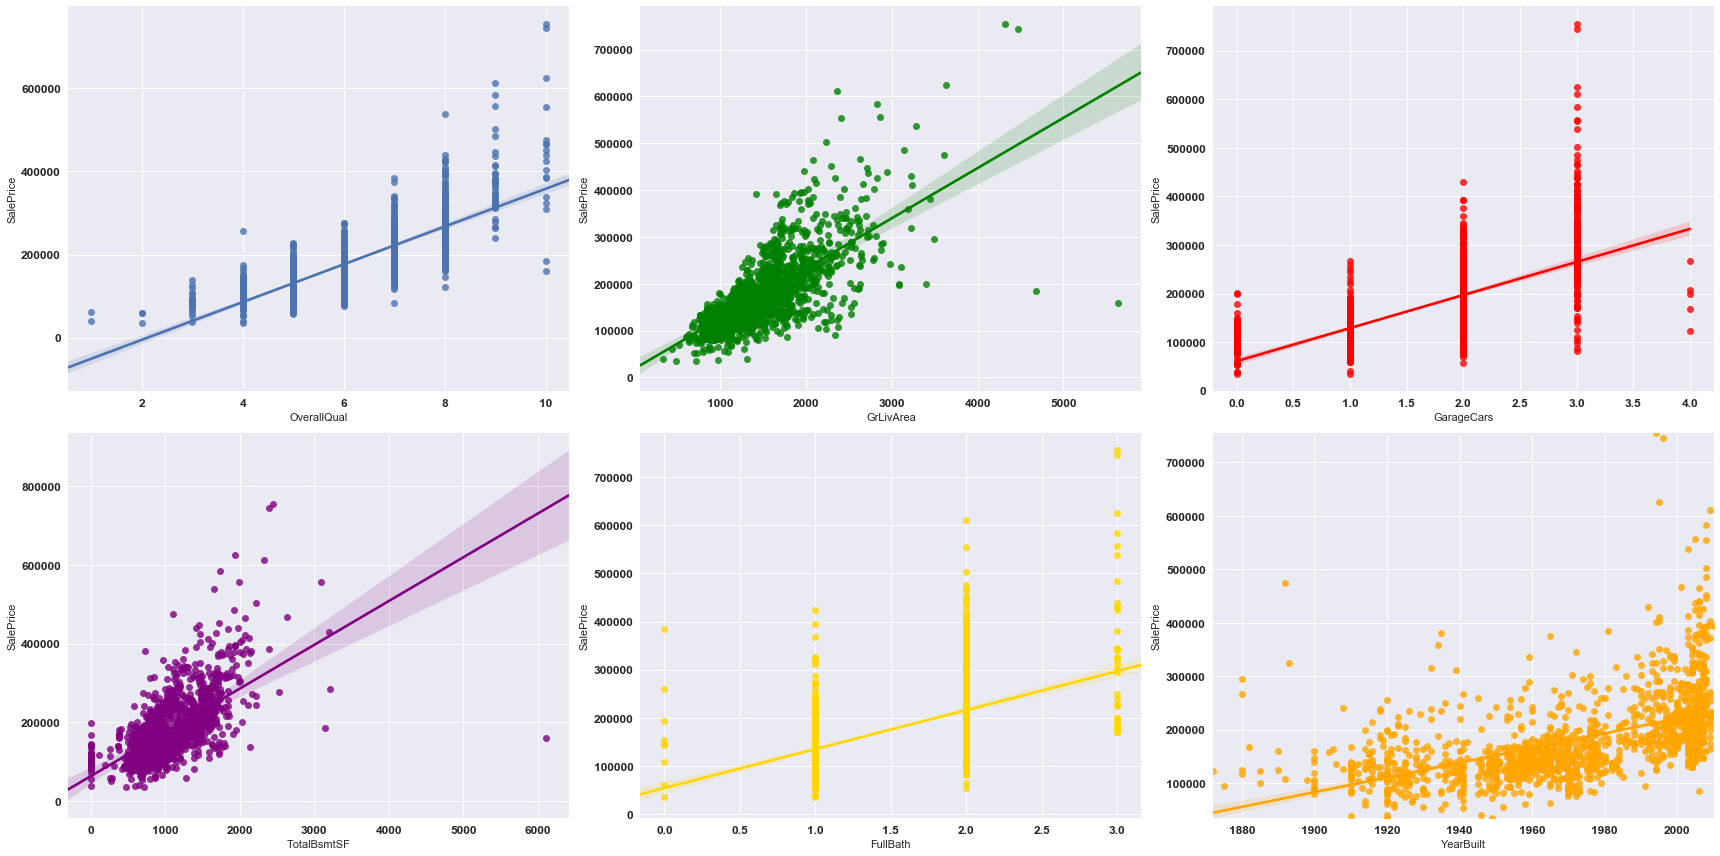

In [12]:
fig, axs = plt.subplots(ncols=3,nrows=2, figsize=(24,12))
seaborn.regplot(x='OverallQual', y='SalePrice', data=train, ax=axs[0,0])
plt.rcParams['ytick.labelsize']=(12)   # tick labels bigger
plt.rcParams['xtick.labelsize']=(12)   # tick labels bigger
plt.rcParams['axes.labelsize']=(24)   # tick labels bigger
seaborn.regplot(x='GrLivArea', y='SalePrice', data=train, ax=axs[0,1],color='green')
seaborn.regplot(x='GarageCars',y='SalePrice', data=train, ax=axs[0,2],truncate=True,color='red')
seaborn.regplot(x='TotalBsmtSF', y='SalePrice', data=train, ax=axs[1,0],color='purple')
seaborn.regplot(x='FullBath', y='SalePrice', data=train, ax=axs[1,1],color='gold')
seaborn.regplot(x='YearBuilt', y='SalePrice', data=train, ax=axs[1,2],color='orange')

axs[1,2].set_xlim(train['YearBuilt'].min(),train['YearBuilt'].max())
axs[1,2].set_ylim(train['SalePrice'].min(),train['SalePrice'].max())


plt.tight_layout()
plt.savefig('Correlated_Scatter_Plots.png', dpi=320)

plt.show()



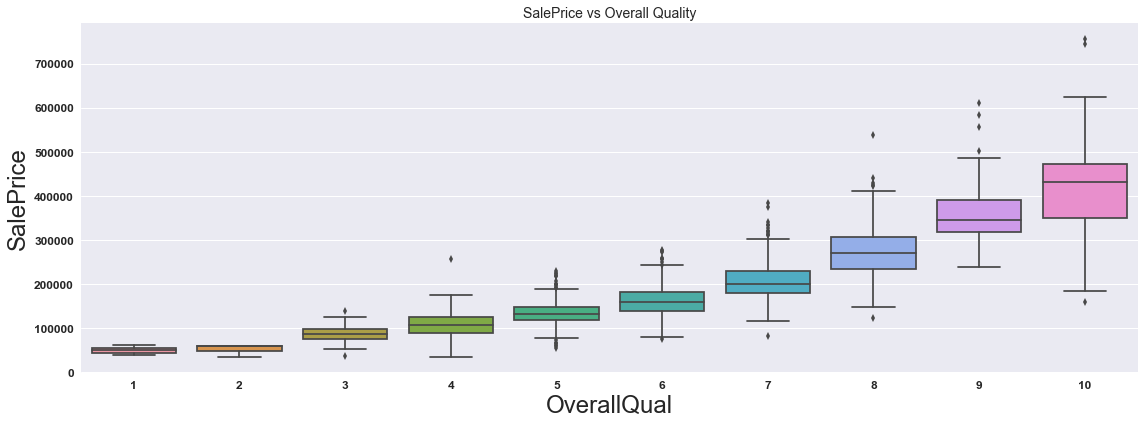

In [13]:
seaborn.boxplot(train['OverallQual'],train['SalePrice'])
plt.title('SalePrice vs Overall Quality',size=14)
matplotlib.rcParams['axes.labelsize']=(12)   # tick labels bigger
fig = plt.gcf()

fig.set_size_inches(16, 6)
plt.tight_layout()

plt.savefig('Boxplots_OverallQual.png', dpi=320)

plt.show()

### We can see 4 huge outliers in GrLivArea vs SalePrice
#### Two of them are 7 standard deviations above the mean but they fit the trend well.
#### Two are much lower than the trend so we will inspect them


In [67]:
outliers = train[train['GrLivArea'] > 4500]
outliers.describe()
outliers_index = train[train['GrLivArea'] > 4500].index

### Both of these properties are massive, one has a pool, both have high MasVnrArea, are newly built, and have overall quality of 10. We should look through all our features to see if we can determine why these houses sold for so little.
    Both are irregularly shaped
    Both are in Edwards (lower cost neighborhood)
    Both have large Stone veener (expensive)
    Both have large square footage and lot areas
    Both are high quality
    Both have excellent bsmt quality with high bsmt exposure
    Both have excellent external quality
    Both have more than 11 rooms above grade...
#### I was hoping that these outliers could be explained by the sale type, possibly a house sold to a family member. However, both of these homes were sold as new and appear to be magnificient. Since none of the variables can explain these homes, both tree and regression models will be severely inaccurate at handling these. We may have to remove them from our model. I would suggest a supervised prediction from the user when properties such as these are detected.

In [68]:
with pd.option_context('display.max_rows', 1000, 'display.max_columns', 1000):
    print outliers
outliers = train[train['GrLivArea'] > 4500]
outliers.describe()
outliers_index = train[train['GrLivArea'] > 4500].index
train = train.drop(train.index[[outliers_index]])


      MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
523           60       RL        130.0    40094   Pave   NaN      IR1   
1298          60       RL        313.0    63887   Pave   NaN      IR3   

     LandContour Utilities LotConfig LandSlope Neighborhood Condition1  \
523          Bnk    AllPub    Inside       Gtl      Edwards       PosN   
1298         Bnk    AllPub    Corner       Gtl      Edwards      Feedr   

     Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  \
523        PosN     1Fam     2Story           10            5       2007   
1298       Norm     1Fam     2Story           10            5       2008   

      YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  \
523           2008       Hip  CompShg     CemntBd     CmentBd      Stone   
1298          2008       Hip  ClyTile      Stucco      Stucco      Stone   

      MasVnrArea ExterQual ExterCond Foundation BsmtQual BsmtCond  \
523        762.0        Ex    

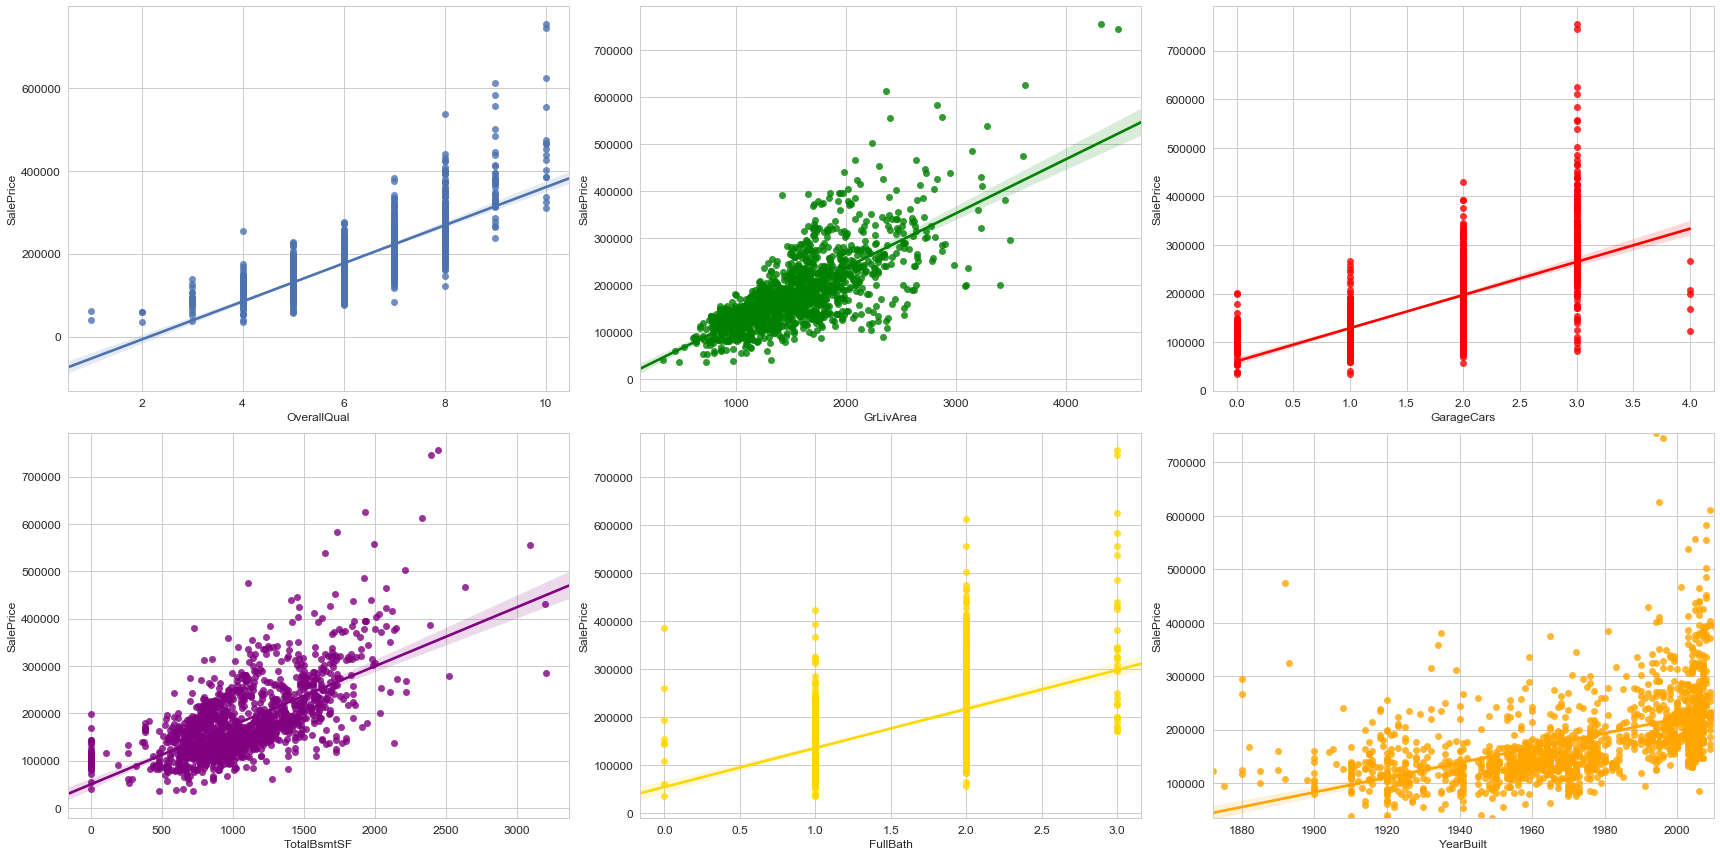

In [69]:
fig, axs = plt.subplots(ncols=3,nrows=2, figsize=(24,12))
seaborn.regplot(x='OverallQual', y='SalePrice', data=train, ax=axs[0,0])
plt.rcParams['ytick.labelsize']=(12)   # tick labels bigger
plt.rcParams['xtick.labelsize']=(12)   # tick labels bigger
plt.rcParams['axes.labelsize']=(24)   # tick labels bigger
seaborn.regplot(x='GrLivArea', y='SalePrice', data=train, ax=axs[0,1],color='green')
seaborn.regplot(x='GarageCars',y='SalePrice', data=train, ax=axs[0,2],truncate=True,color='red')
seaborn.regplot(x='TotalBsmtSF', y='SalePrice', data=train, ax=axs[1,0],color='purple')
seaborn.regplot(x='FullBath', y='SalePrice', data=train, ax=axs[1,1],color='gold')
seaborn.regplot(x='YearBuilt', y='SalePrice', data=train, ax=axs[1,2],color='orange')

axs[1,2].set_xlim(train['YearBuilt'].min(),train['YearBuilt'].max())
axs[1,2].set_ylim(train['SalePrice'].min(),train['SalePrice'].max())


plt.tight_layout()
plt.savefig('Correlated_Scatter_Plots2.png', dpi=320)

plt.show()



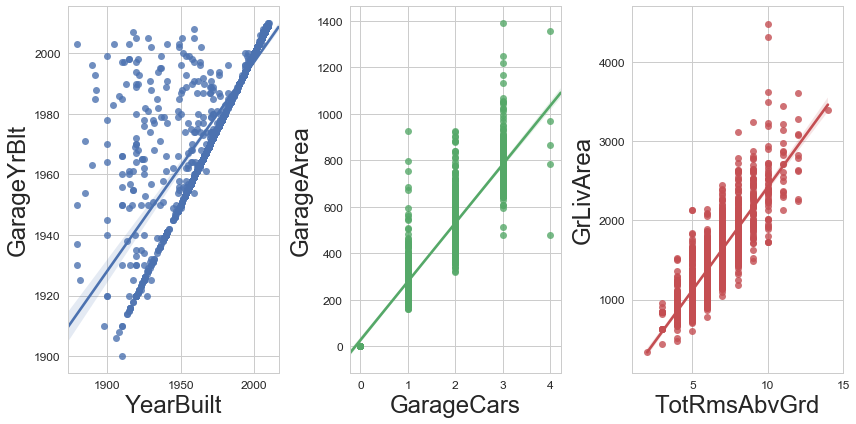

In [70]:
fig, axs = plt.subplots(ncols=3, figsize=(12,6))
seaborn.regplot(x='YearBuilt', y='GarageYrBlt', data=train, ax=axs[0])
seaborn.regplot(x='GarageCars', y='GarageArea', data=train, ax=axs[1])
seaborn.regplot(x='TotRmsAbvGrd',y='GrLivArea', data=train, ax=axs[2],truncate=True)
axs[2].set_xlim(1,15)

plt.tight_layout()
plt.savefig('Correlated_Features_Example.png', dpi=320)

plt.show()

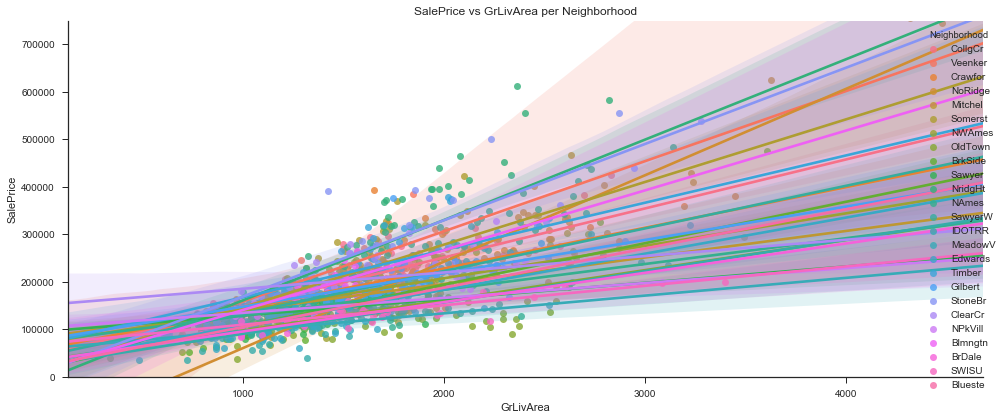

In [71]:
seaborn.set(style="ticks")
seaborn.lmplot(x="GrLivArea", y='SalePrice', hue='Neighborhood', data=train)
plt.ylim(0,750000)
plt.title('SalePrice vs GrLivArea per Neighborhood',size=12)
matplotlib.rcParams['font.weight']=('bold')    # bold fonts are easier to see
matplotlib.rcParams['ytick.labelsize']=(16)   # tick labels bigger
matplotlib.rcParams['xtick.labelsize']=(16)   # tick labels bigger
fig = plt.gcf()

fig.set_size_inches(14, 6)
plt.tight_layout()

plt.savefig('RegPlot_SalePrice_GrLivArea_Neighborhoods.png', dpi=320)

plt.show()

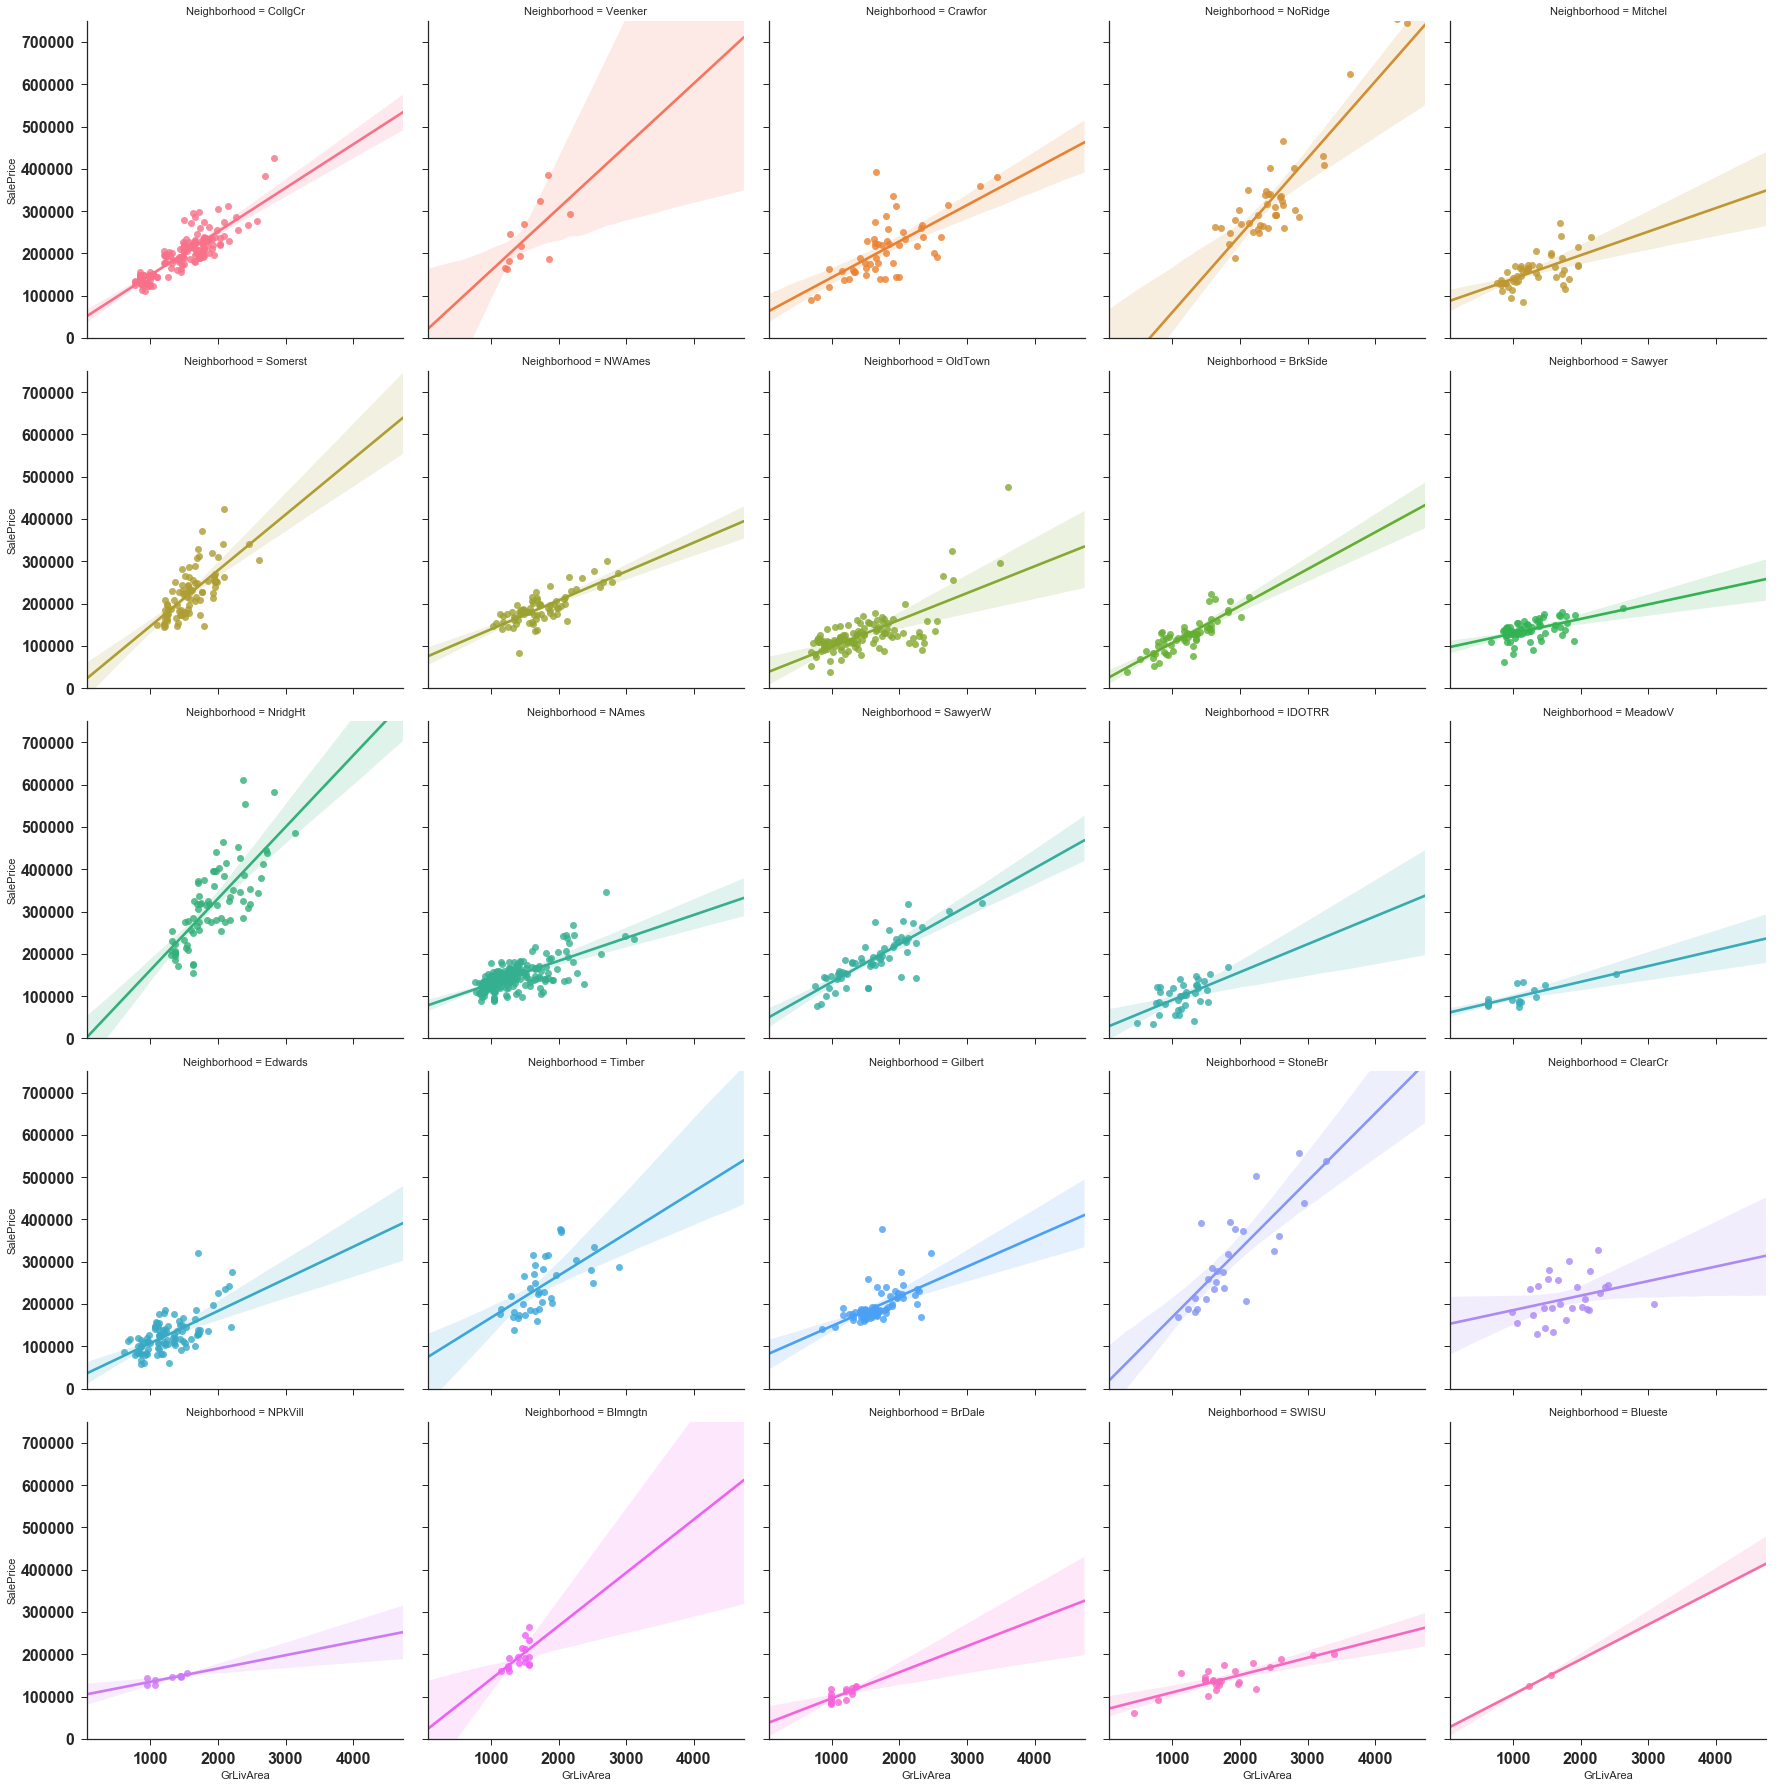

In [19]:
g = seaborn.lmplot(x="GrLivArea", y="SalePrice", col="Neighborhood", hue="Neighborhood",
         data=train, col_wrap=5, size=5)
g.set(ylim=(0,750000))

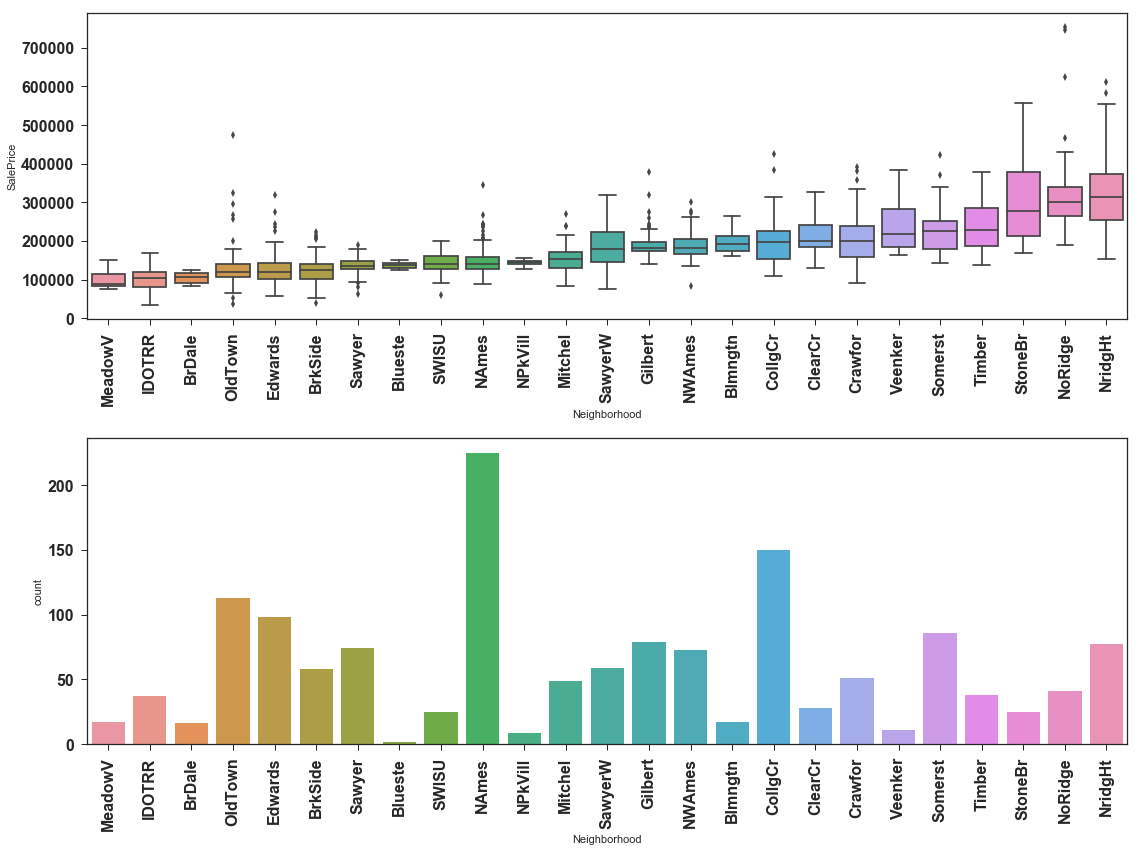

In [20]:
neighborhood_medians = train['SalePrice'].groupby(train['Neighborhood']).median()
neighborhood_sorted = neighborhood_medians.sort_values()
neighborhood_names_sorted = list(neighborhood_sorted.index)

fig, (ax1,ax2) = plt.subplots(2, figsize=(16,12))
matplotlib.rcParams['axes.labelsize']=(18)   # tick labels bigger

seaborn.boxplot('Neighborhood','SalePrice', data=train,ax=ax1,order=neighborhood_names_sorted)
seaborn.countplot(x="Neighborhood", data=train,ax=ax2,order=neighborhood_names_sorted)
for ax in fig.axes:
    plt.sca(ax)
    plt.xticks(rotation=90)

    
plt.tight_layout()

plt.savefig('BoxPlots_Neighborhood.png', dpi=320)

plt.show()




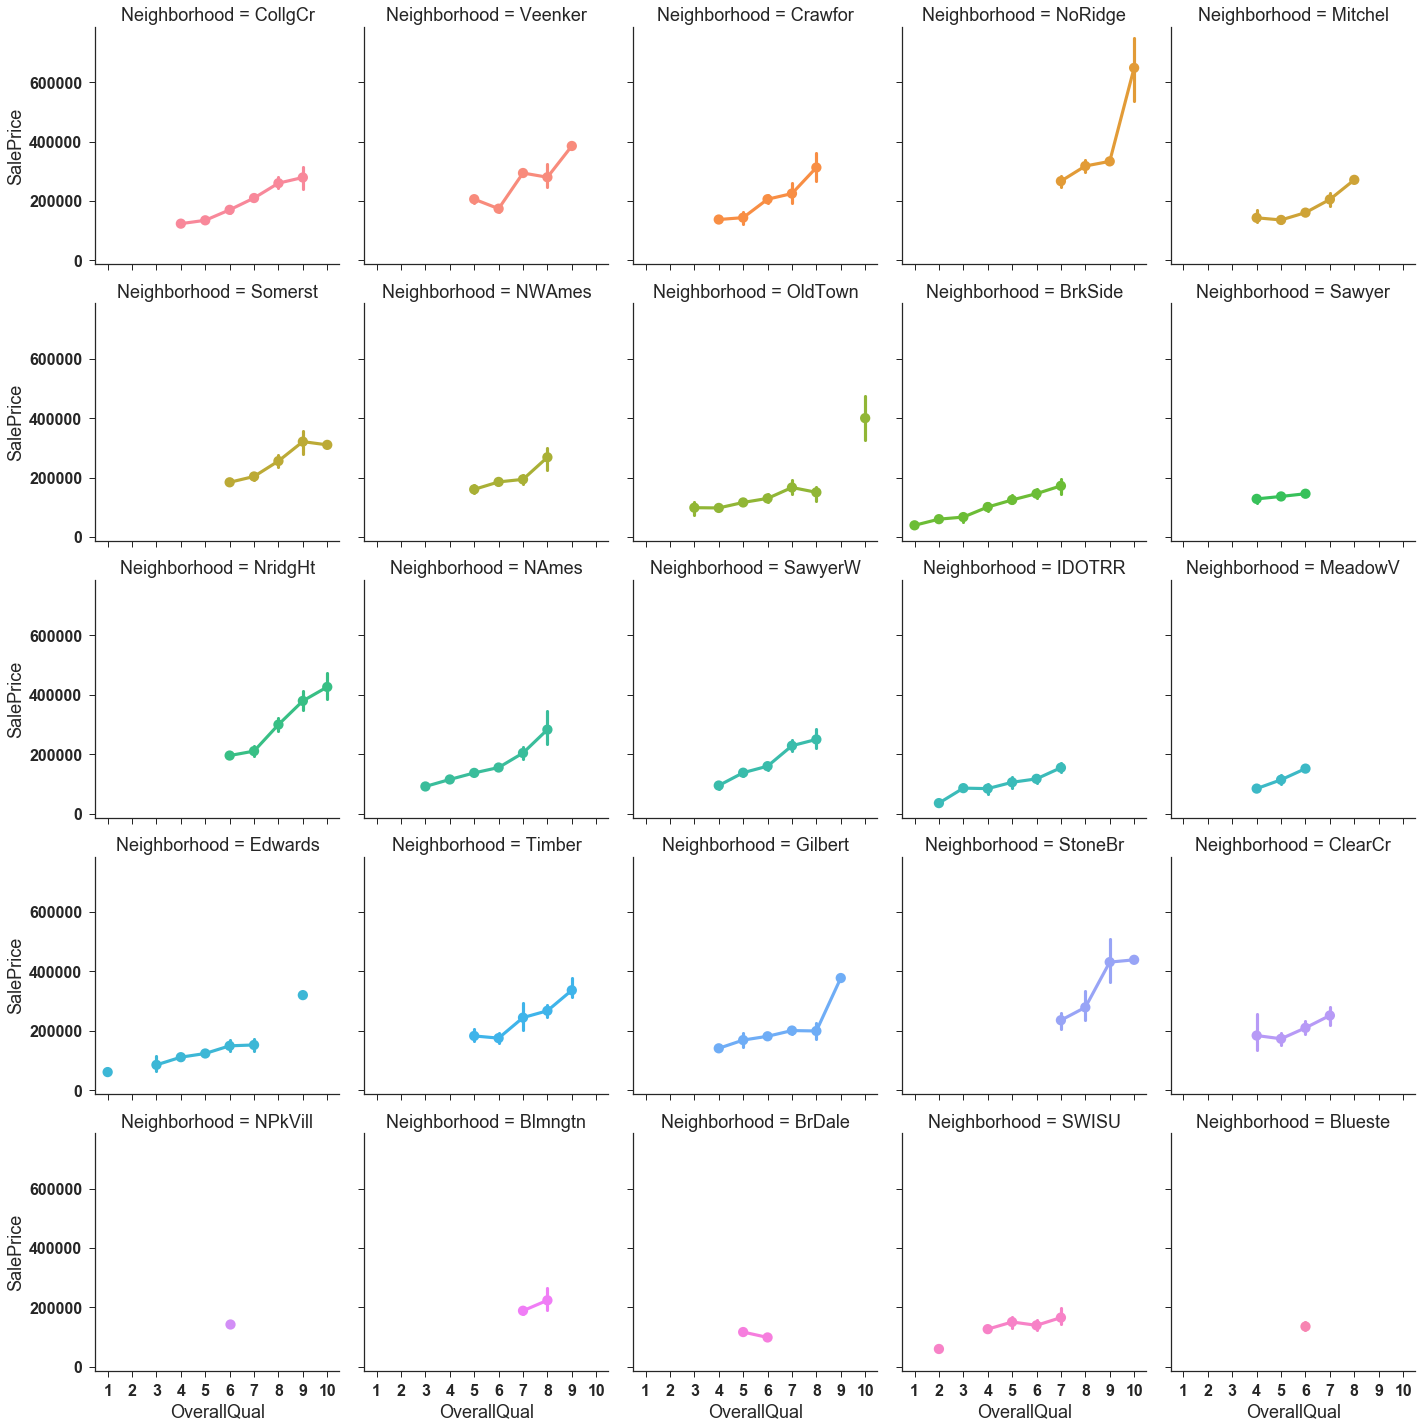

In [21]:
seaborn.factorplot(x="OverallQual", y="SalePrice", col="Neighborhood", hue="Neighborhood",
         data=train, col_wrap=5, size=4)

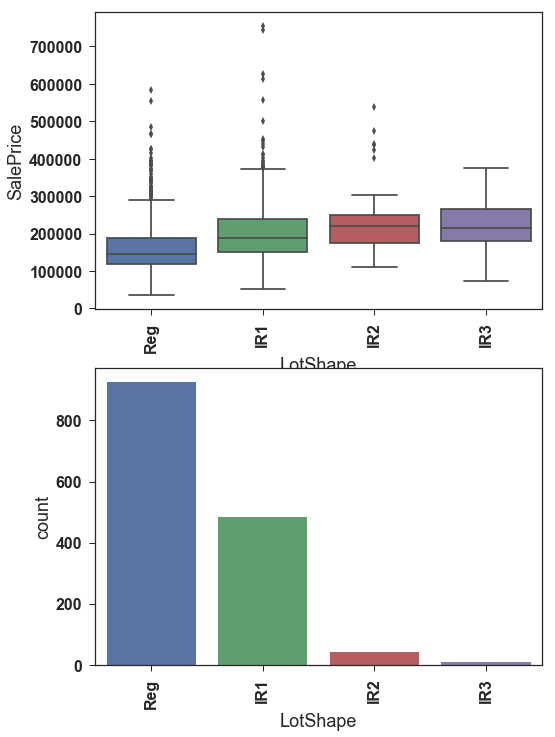

In [22]:
fig, (ax1,ax2) = plt.subplots(2, figsize=(8,12))
seaborn.boxplot('LotShape','SalePrice', data=train,ax=ax1)
seaborn.countplot(x="LotShape", data=train,ax=ax2)
for ax in fig.axes:
    plt.sca(ax)
    plt.xticks(rotation=90)
plt.show()


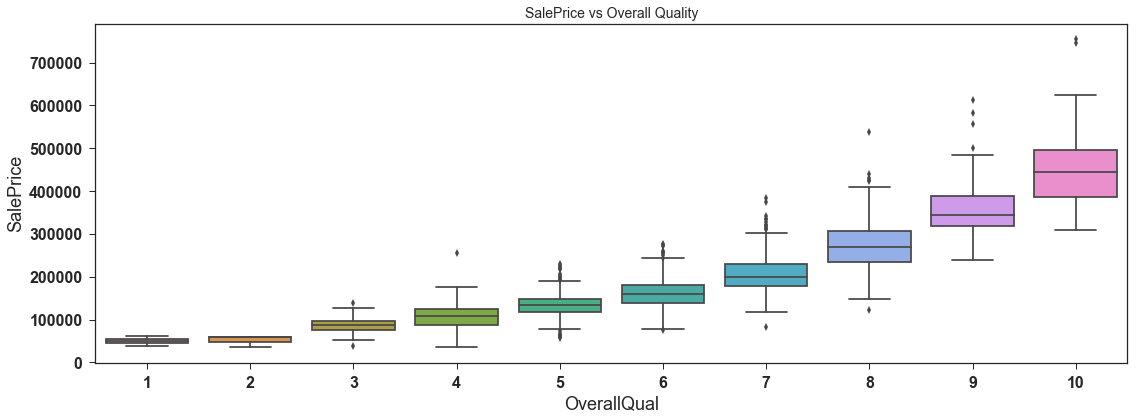

In [23]:
seaborn.boxplot(train['OverallQual'],train['SalePrice'])
plt.title('SalePrice vs Overall Quality',size=14)
matplotlib.rcParams['axes.labelsize']=(12)   # tick labels bigger
fig = plt.gcf()

fig.set_size_inches(16, 6)
plt.tight_layout()

plt.savefig('Boxplots_OverallQual.png', dpi=320)

plt.show()

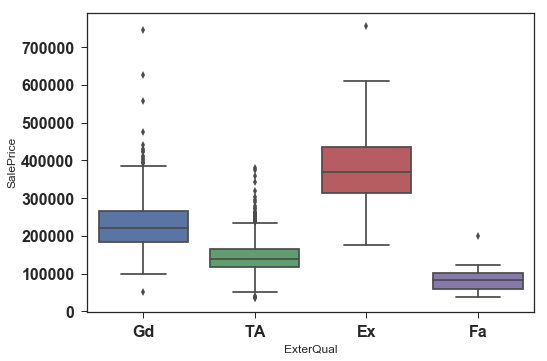

In [24]:
seaborn.boxplot(train['ExterQual'],train['SalePrice'])


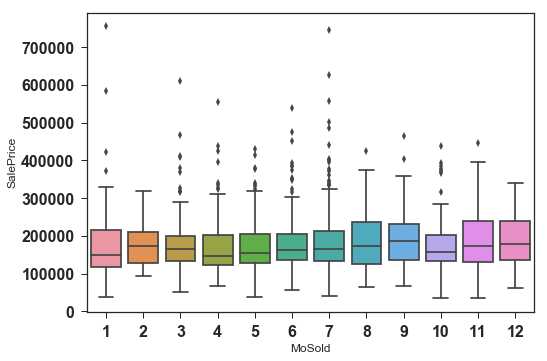

In [25]:
seaborn.boxplot(train['MoSold'],train['SalePrice'])


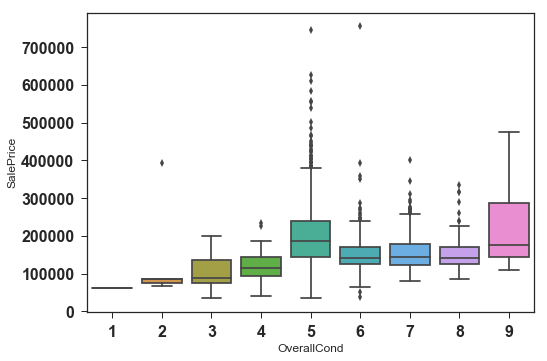

In [26]:
seaborn.boxplot(train['OverallCond'],train['SalePrice'])


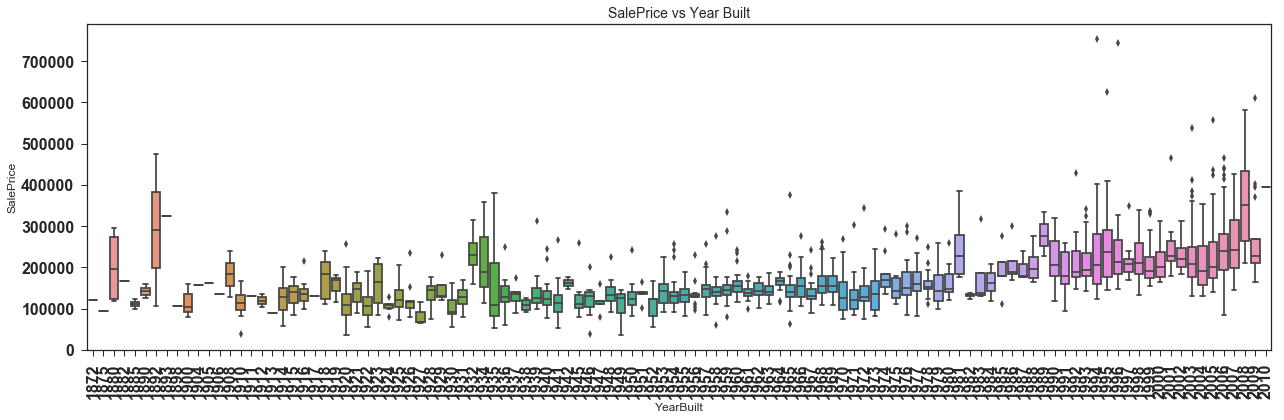

In [27]:
seaborn.boxplot(train['YearBuilt'],train['SalePrice'])
plt.xticks(rotation=90)
plt.title('SalePrice vs Year Built',size=14)
plt.rcParams['font.weight']=('normal')    # bold fonts are easier to see
plt.rcParams['axes.labelsize']=(12)   # tick labels bigger

plt.rcParams['ytick.labelsize']=(12)   # tick labels bigger

plt.rcParams['xtick.labelsize']=(12)   # tick labels bigger

fig = plt.gcf()

fig.set_size_inches(18, 6)
plt.tight_layout()

plt.savefig('Boxplots_YearBuilt.png', dpi=320)

plt.show()

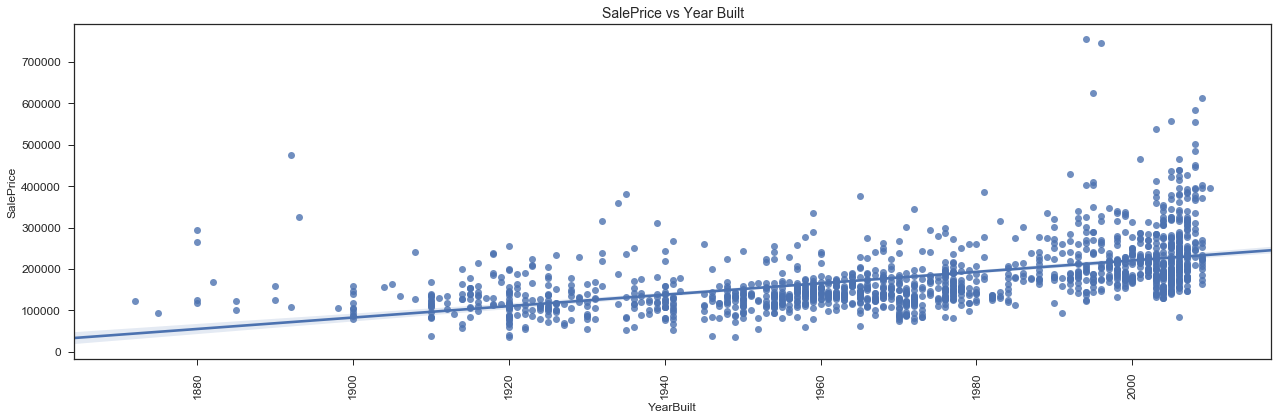

In [28]:
fig, ax = plt.subplots(figsize=(16, 8))
fig = seaborn.regplot(train['YearBuilt'],train['SalePrice'])
plt.xticks(rotation=90)
plt.title('SalePrice vs Year Built',size=14)
plt.rcParams['font.weight']=('normal')    # bold fonts are easier to see
plt.rcParams['axes.labelsize']=(12)   # tick labels bigger

plt.rcParams['ytick.labelsize']=(12)   # tick labels bigger

plt.rcParams['xtick.labelsize']=(12)   # tick labels bigger

fig = plt.gcf()

fig.set_size_inches(18, 6)
plt.tight_layout()

plt.savefig('RegPlot_YearBuilt.png', dpi=320)

plt.show()

## Dealing with null values

In [72]:
def check_null(data):
    null_check = data.isnull()
    null_counts = null_check.sum()
    total_counts = null_check.count()
    percent_null = null_counts/total_counts
    percent_null.sort(ascending=False, inplace=True)
    print(percent_null[percent_null>0])
check_null(train)

PoolQC          0.995885
MiscFeature     0.962963
Alley           0.937586
Fence           0.807270
FireplaceQu     0.473251
LotFrontage     0.177641
GarageType      0.055556
GarageCond      0.055556
GarageFinish    0.055556
GarageQual      0.055556
GarageYrBlt     0.055556
BsmtFinType2    0.026063
BsmtExposure    0.026063
BsmtQual        0.025377
BsmtCond        0.025377
BsmtFinType1    0.025377
MasVnrArea      0.005487
MasVnrType      0.005487
Electrical      0.000686
dtype: float64


/Users/triciangoon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:6: FutureWarning: sort is deprecated, use sort_values(inplace=True) for INPLACE sorting


## Replacing null with "None" based on description of data:
    Alley
    BsmtQual
    BsmtCond
    BsmtExposure
    BsmtFinType1
    BsmtFinType2
    FireplaceQu
    GarageType
    GarageFinish
    GarageQual
    GarageCond
    PoolQC
    Fence
    MiscFeature


In [73]:
replace_with_none = ['Alley',
                    'BsmtQual',
                     'BsmtCond',
                     'BsmtExposure',
                     'BsmtFinType1',
                     'BsmtFinType2',
                     'FireplaceQu',
                     'GarageType',
                     'GarageFinish',
                     'GarageQual',
                     'GarageCond',
                     'PoolQC',
                     'Fence',
                     'MiscFeature']

train[replace_with_none] = train[replace_with_none].fillna('None')

In [74]:
check_null(train)

LotFrontage    0.177641
GarageYrBlt    0.055556
MasVnrType     0.005487
MasVnrArea     0.005487
Electrical     0.000686
dtype: float64


/Users/triciangoon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:6: FutureWarning: sort is deprecated, use sort_values(inplace=True) for INPLACE sorting


## Much better! Only 5 features with null values now.
## With only 1 null element in electrical we can probably replace it with the median

In [75]:
train['Electrical'] = train['Electrical'].fillna(train['Electrical'].value_counts().idxmax())

In [76]:
check_null(train)

LotFrontage    0.177641
GarageYrBlt    0.055556
MasVnrType     0.005487
MasVnrArea     0.005487
dtype: float64


/Users/triciangoon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:6: FutureWarning: sort is deprecated, use sort_values(inplace=True) for INPLACE sorting


## Checking the MasVnrType/Area null entries

In [77]:
with pd.option_context('display.max_rows', None, 'display.max_columns', 1000):
    print train[train['MasVnrType'].isnull()]

      MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
234           60       RL          NaN     7851   Pave  None      Reg   
529           20       RL          NaN    32668   Pave  None      IR1   
650           60       FV         65.0     8125   Pave  None      Reg   
936           20       RL         67.0    10083   Pave  None      Reg   
973           20       FV         95.0    11639   Pave  None      Reg   
977          120       FV         35.0     4274   Pave  Pave      IR1   
1243          20       RL        107.0    13891   Pave  None      Reg   
1278          60       RL         75.0     9473   Pave  None      Reg   

     LandContour Utilities LotConfig LandSlope Neighborhood Condition1  \
234          Lvl    AllPub    Inside       Gtl      Gilbert       Norm   
529          Lvl    AllPub   CulDSac       Gtl      Crawfor       Norm   
650          Lvl    AllPub    Inside       Gtl      Somerst       Norm   
936          Lvl    AllPub    Inside       Gtl

## Nothing seems out of the ordinary with the 8 properties, so lets replace the missing values with the median

In [78]:
train['MasVnrType'] = train['MasVnrType'].fillna(train['MasVnrType'].value_counts().idxmax())
train['MasVnrArea'] = train['MasVnrArea'].fillna(train['MasVnrArea'].mean())


In [79]:
check_null(train)

LotFrontage    0.177641
GarageYrBlt    0.055556
dtype: float64


/Users/triciangoon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:6: FutureWarning: sort is deprecated, use sort_values(inplace=True) for INPLACE sorting


## Replace a few values with mean

In [80]:
train['GarageYrBlt'] = train['GarageYrBlt'].fillna(train['GarageYrBlt'].mean())

## Lot frontage seems to be correlated with sales price so we want to keep it. 17% missing data is a lot though

In [81]:
print(train[train['LotFrontage'].isnull()]['SalePrice'].mean())
print(train['SalePrice'].mean())

181620.073359
180932.919067


## The properties with null LotFrontage seem to have identical mean to the total sample. This might be a good place to replace with mean value

In [82]:
train['LotFrontage'] = train['LotFrontage'].fillna(train['LotFrontage'].mean())
check_null(train)

Series([], dtype: float64)


/Users/triciangoon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:6: FutureWarning: sort is deprecated, use sort_values(inplace=True) for INPLACE sorting


#### Lets look at "all the things" (categorically)

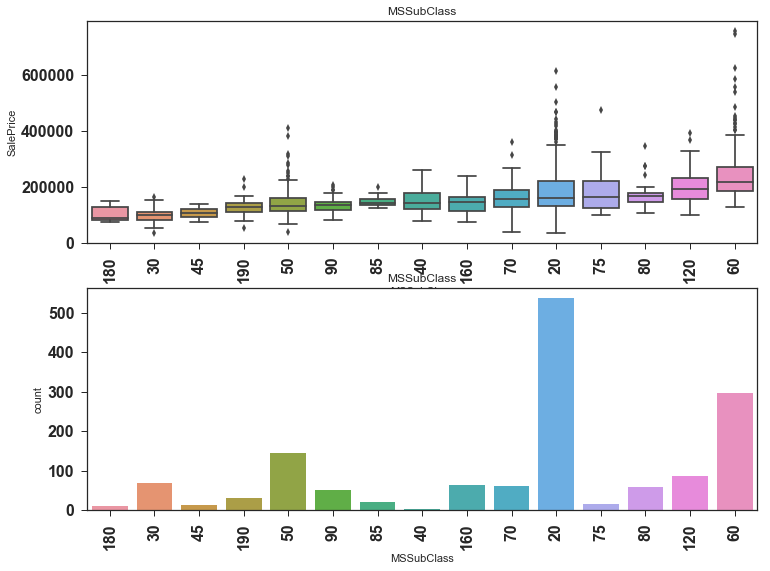

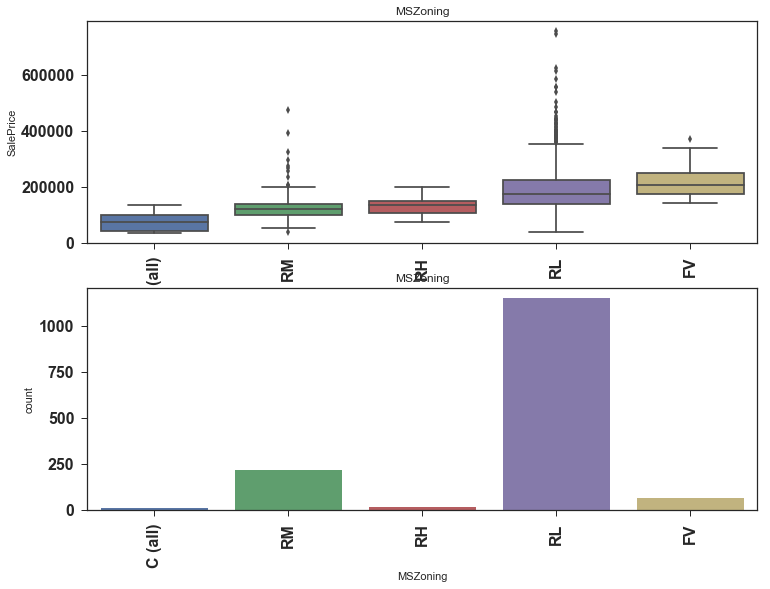

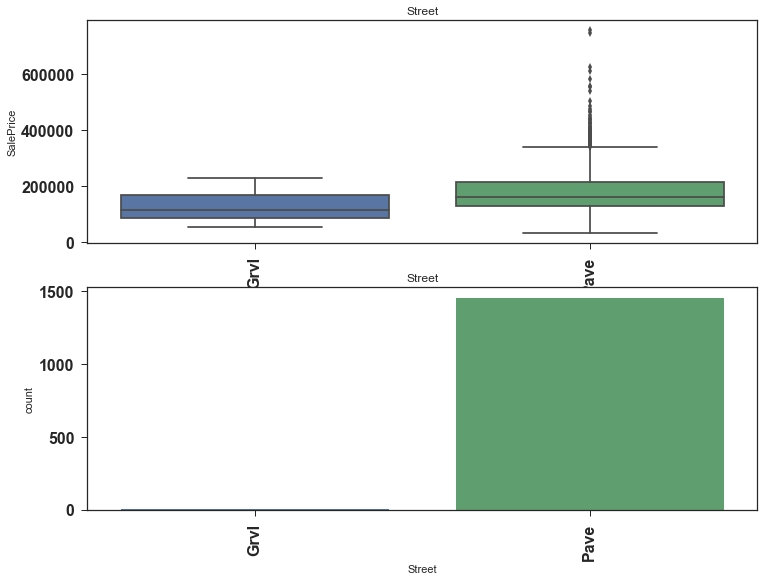

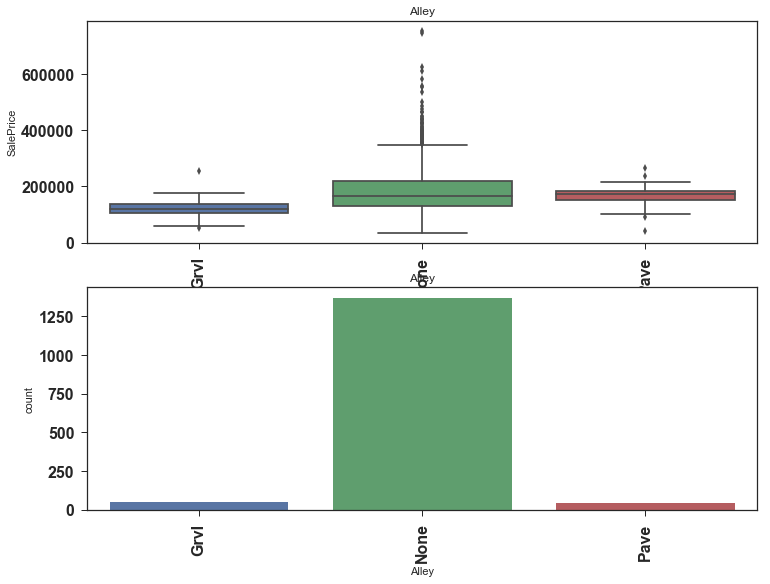

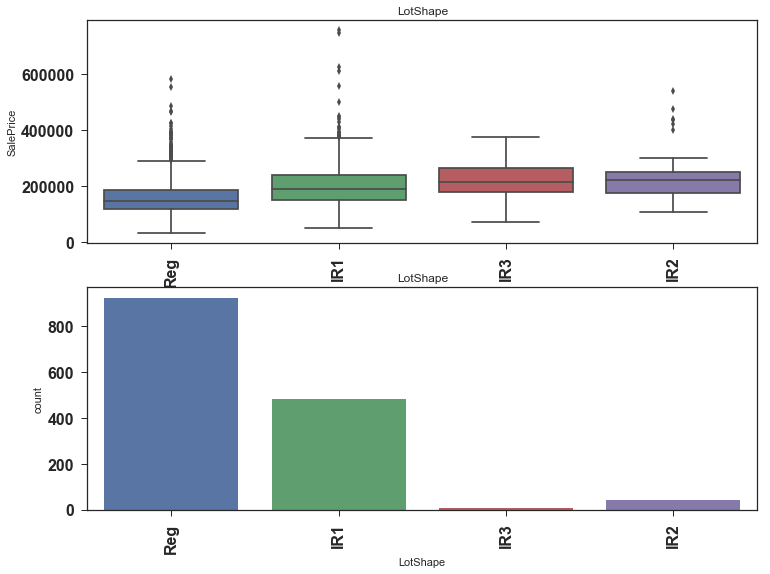

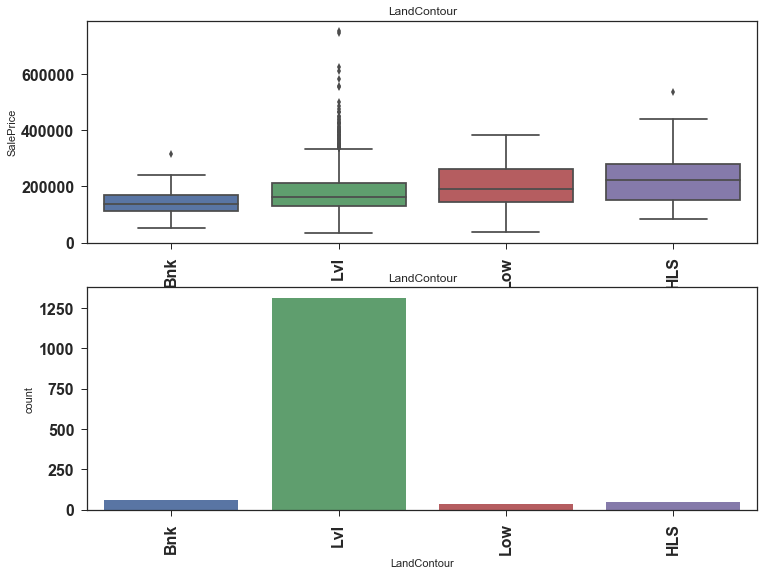

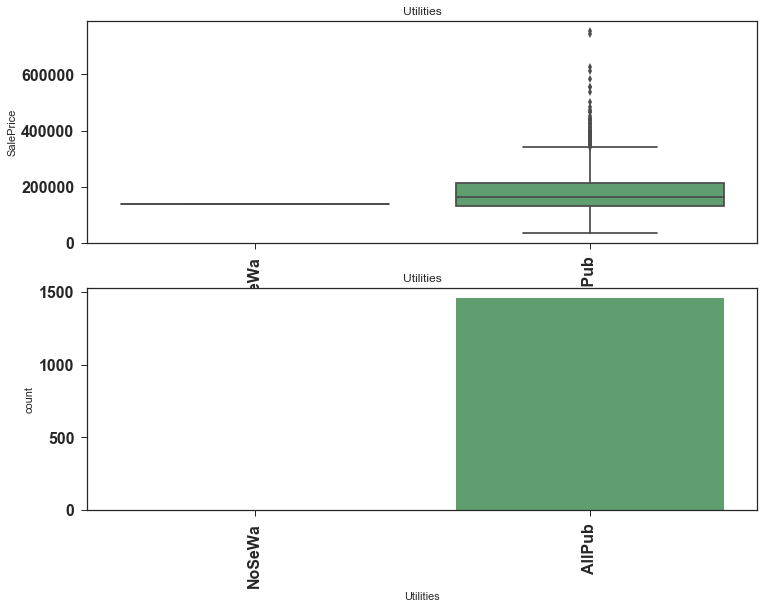

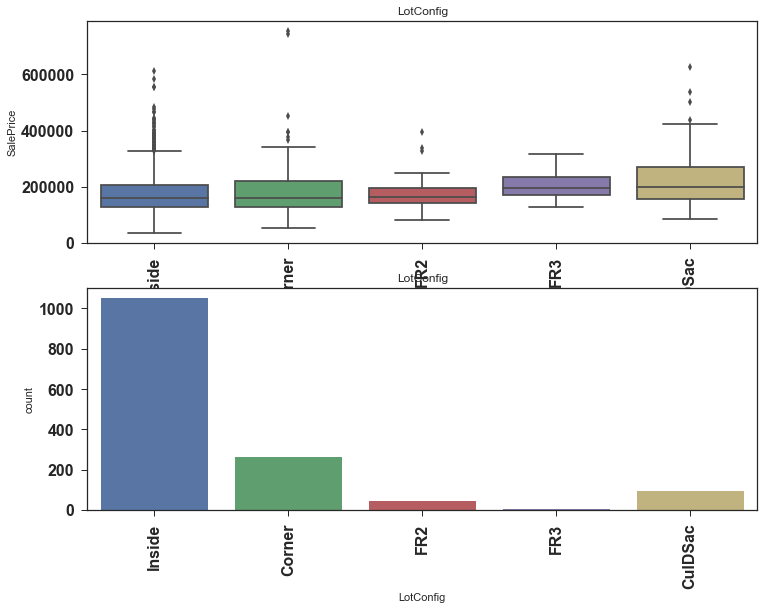

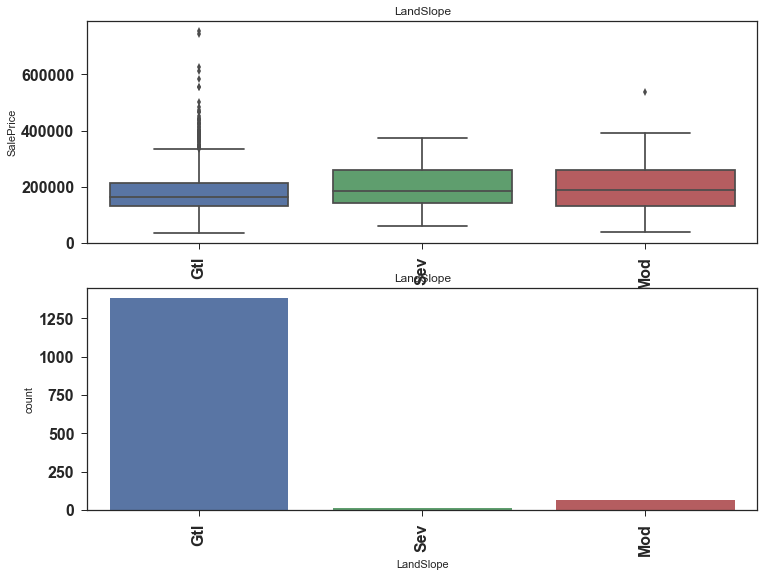

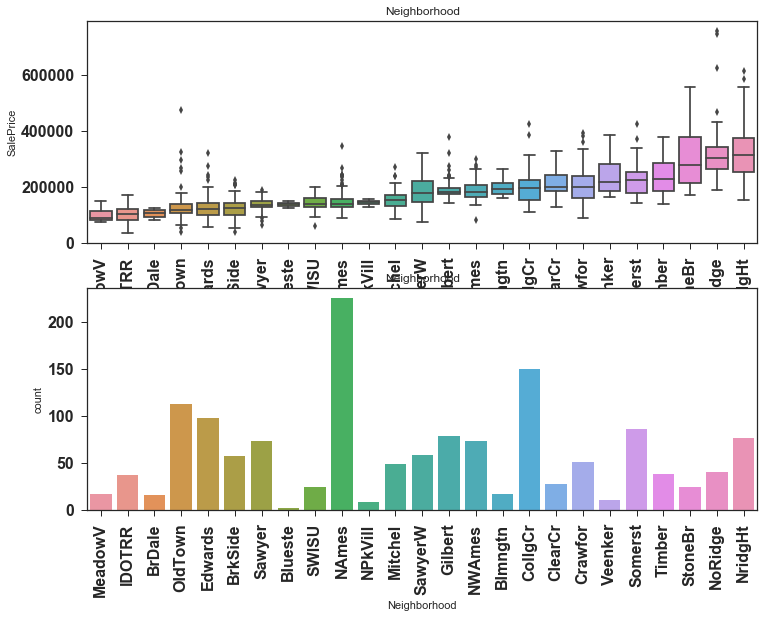

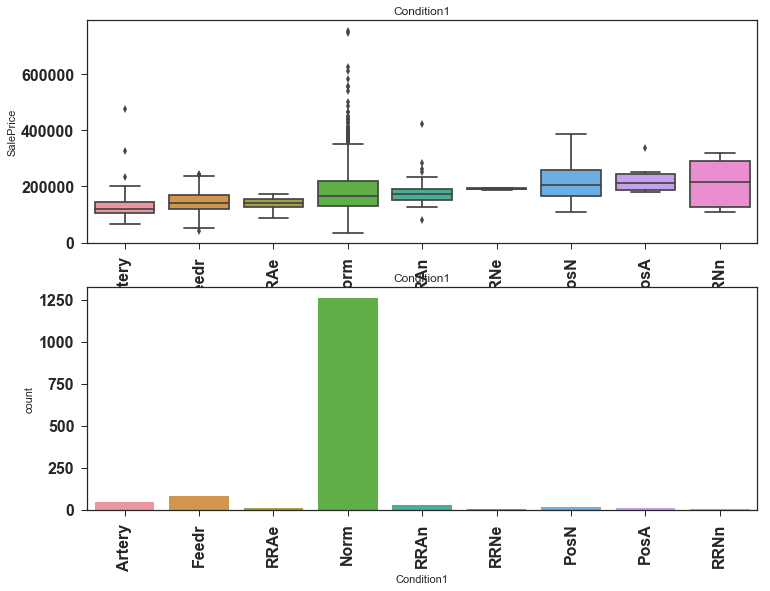

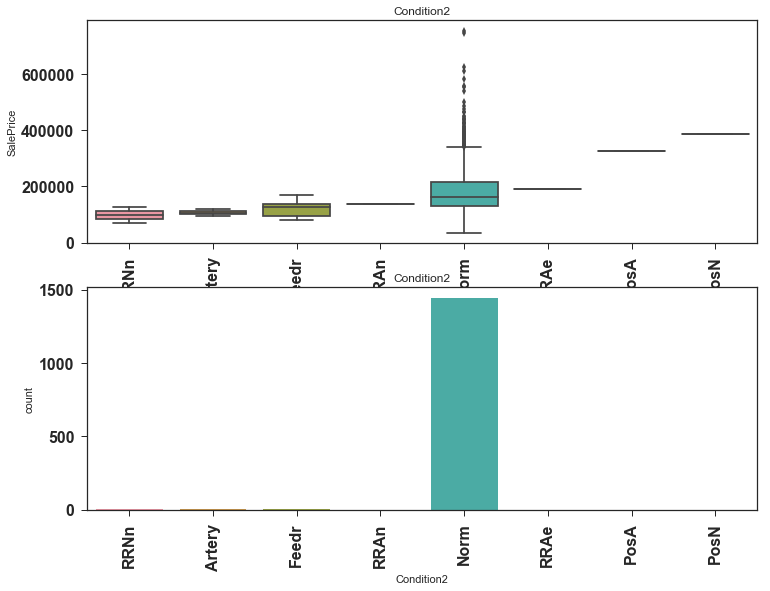

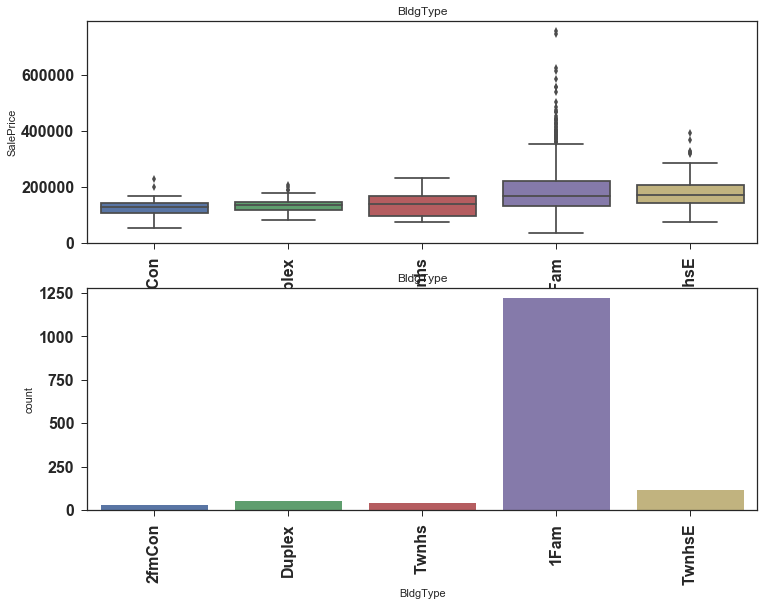

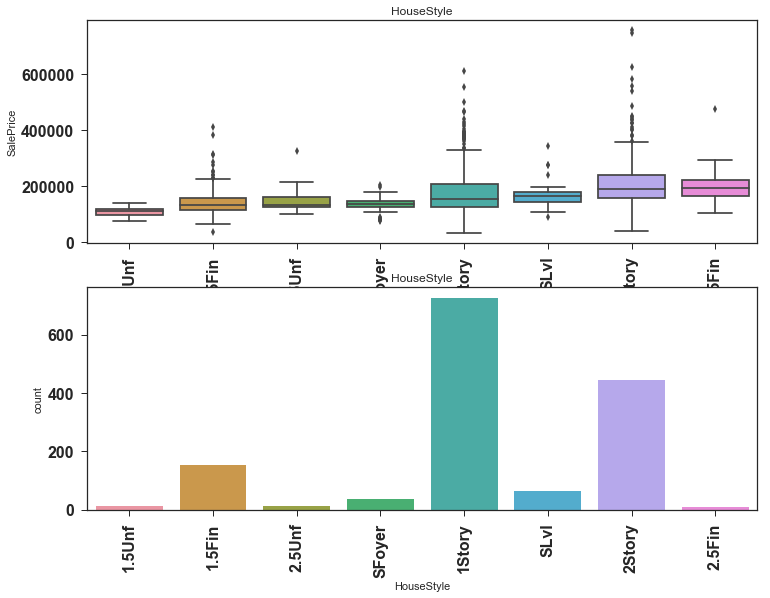

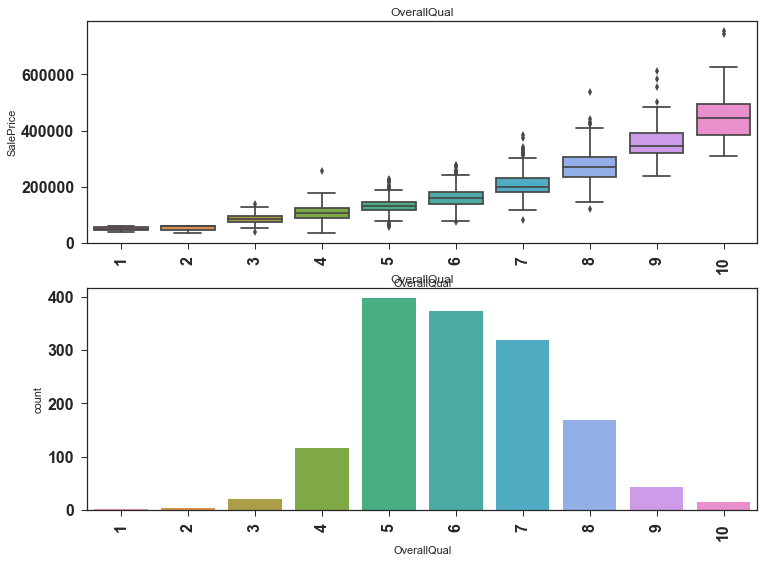

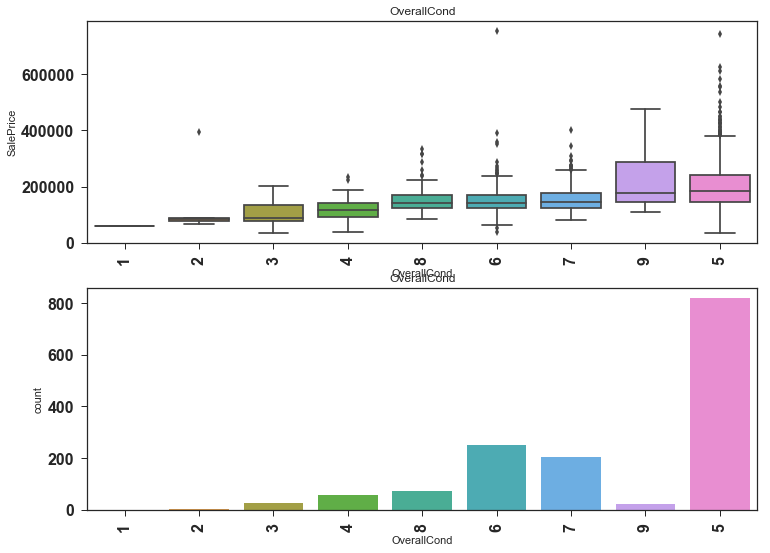

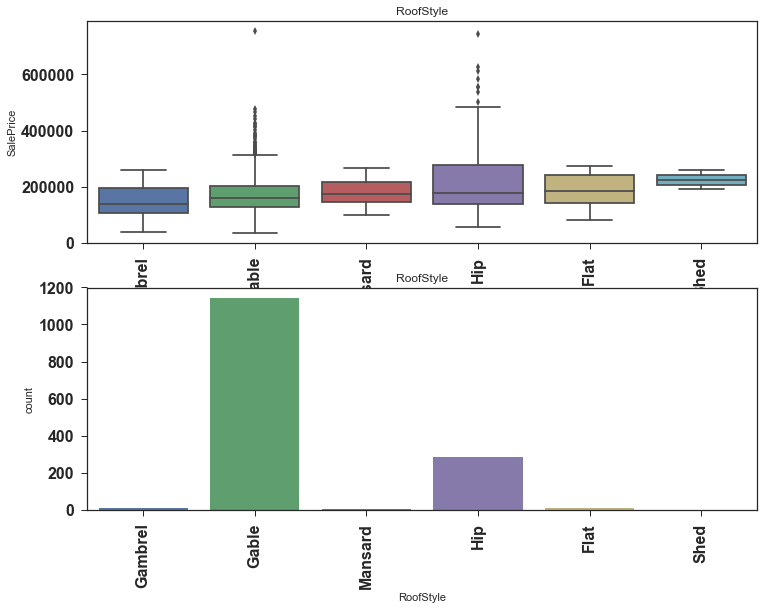

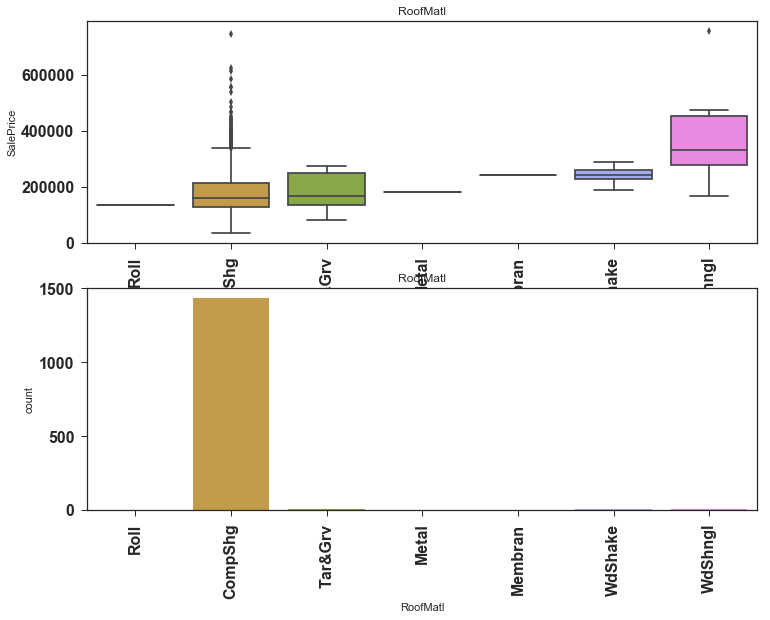

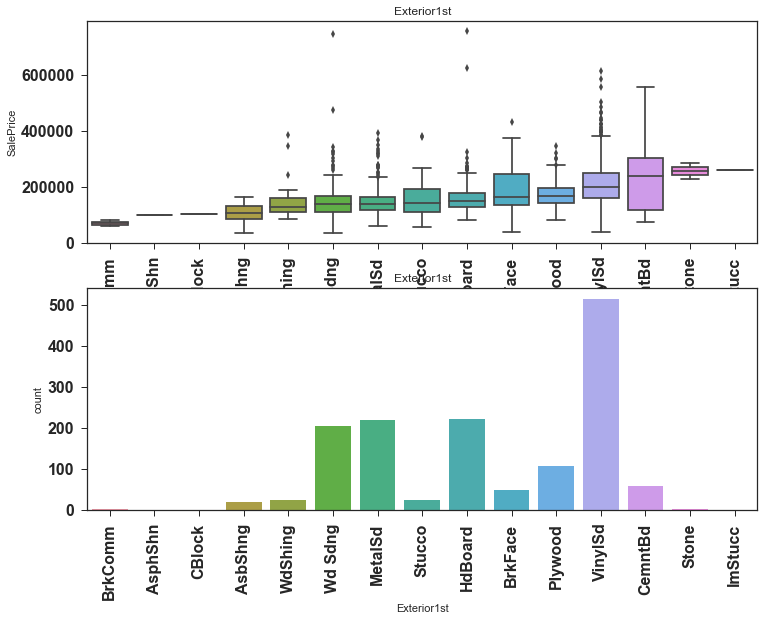

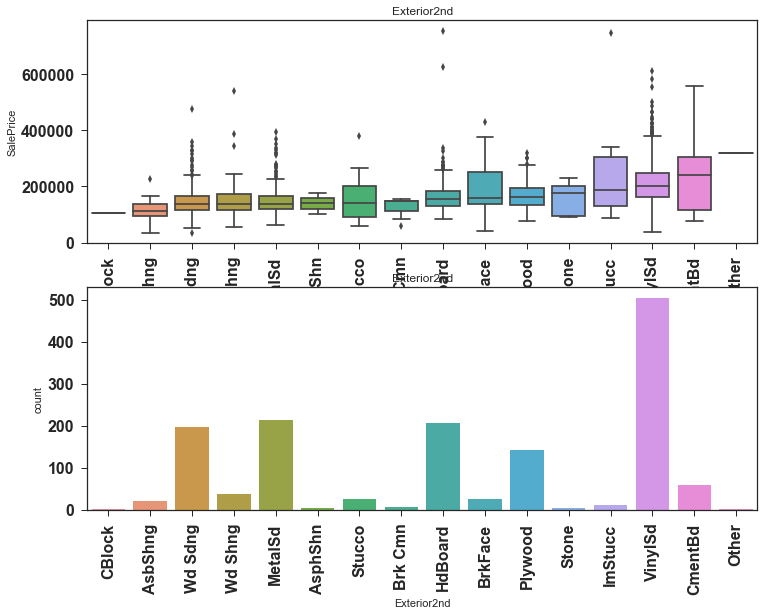

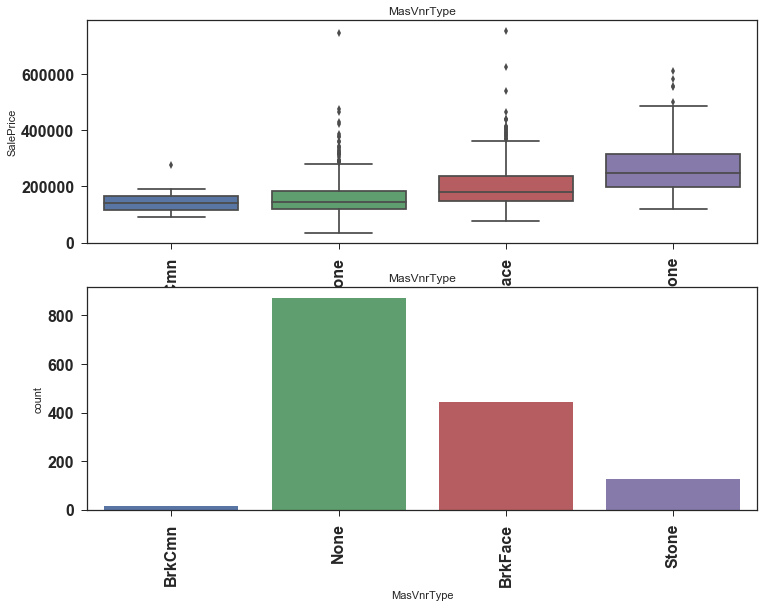

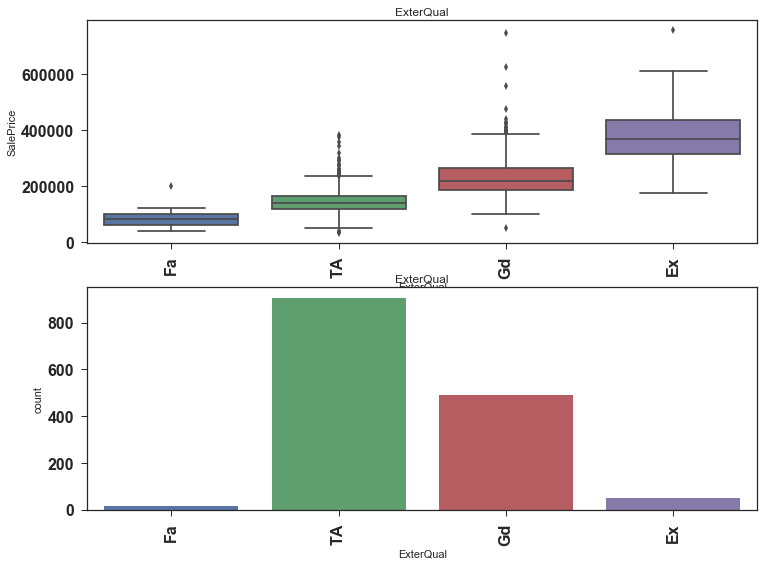

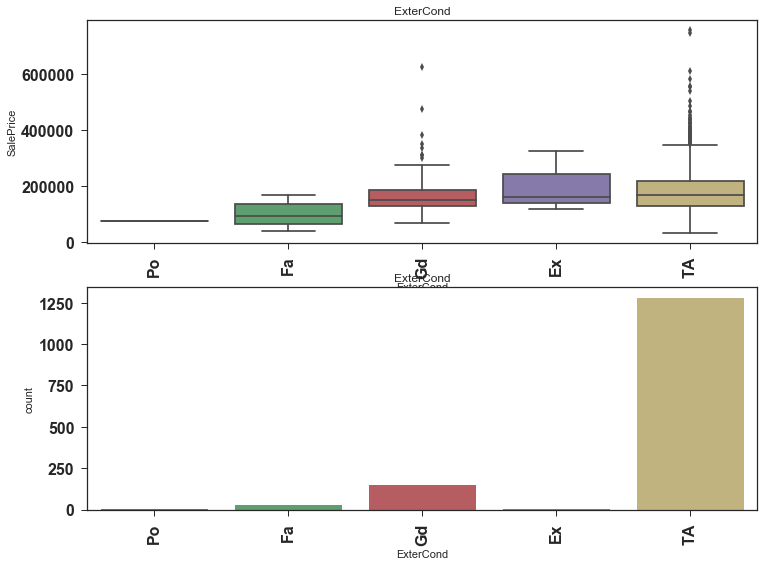

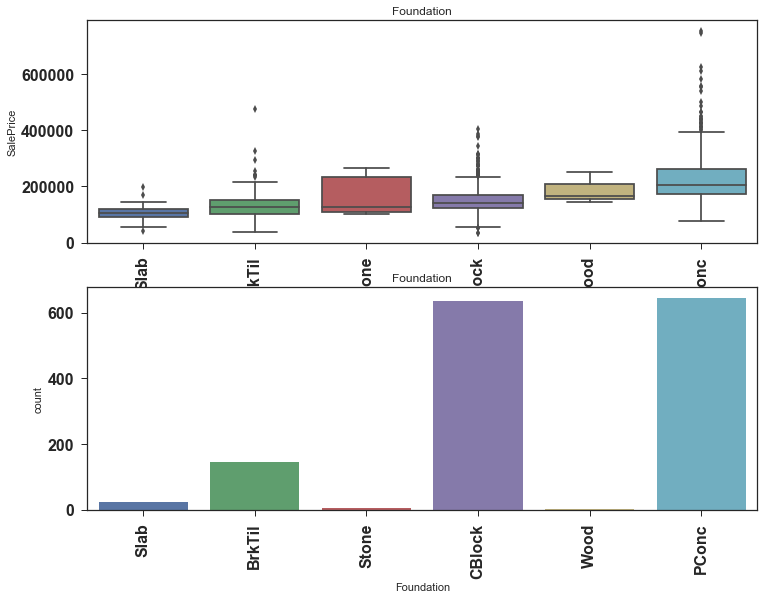

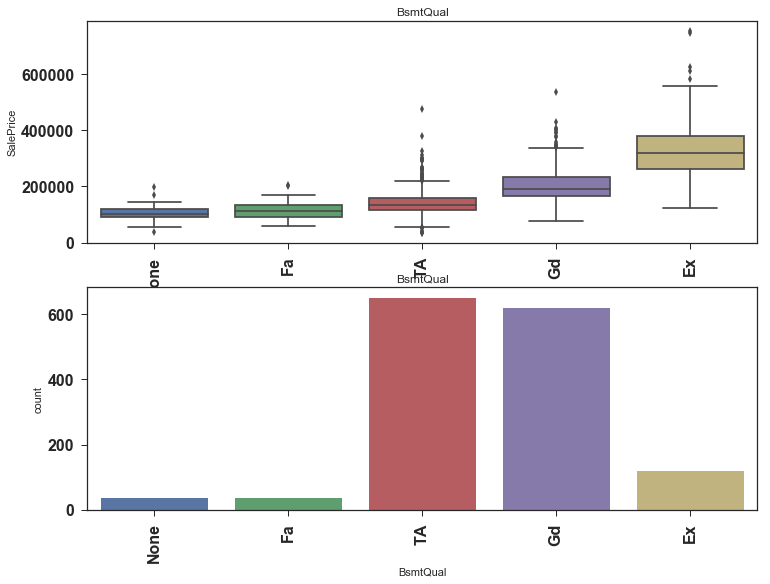

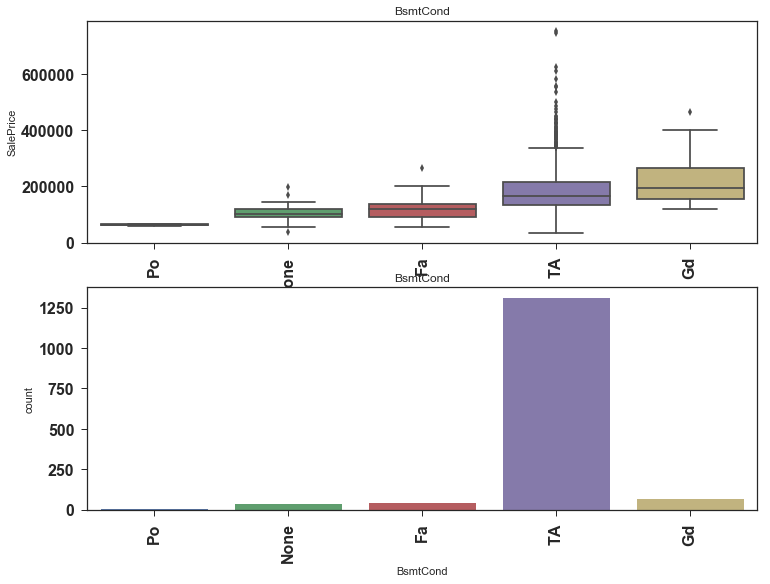

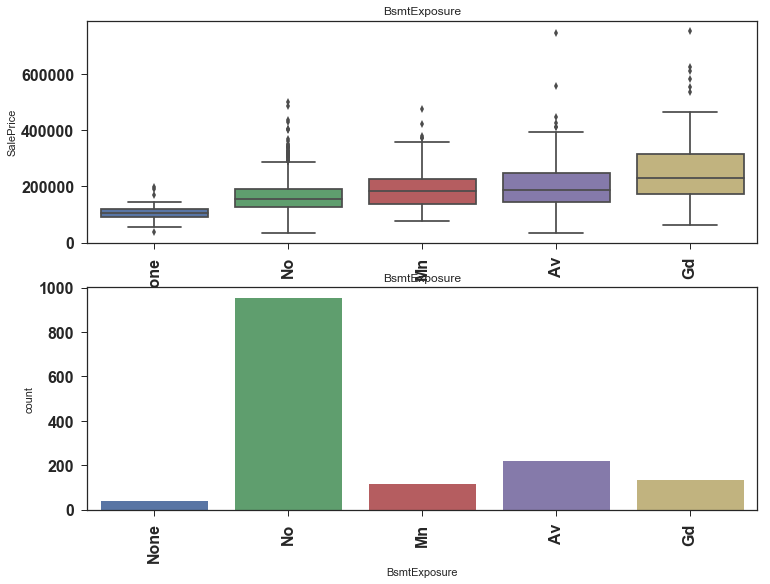

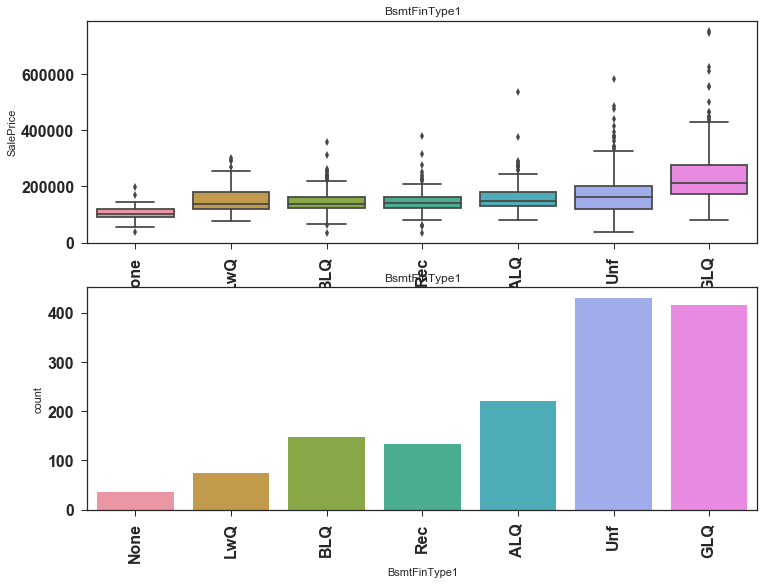

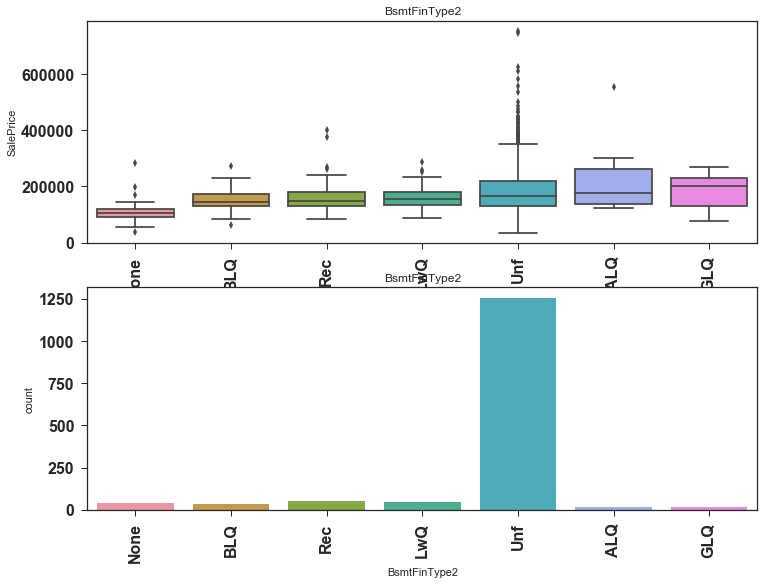

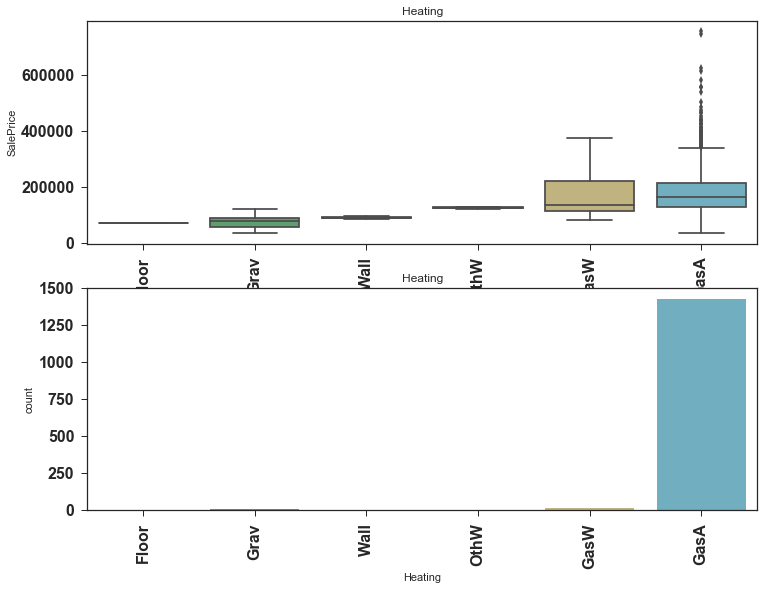

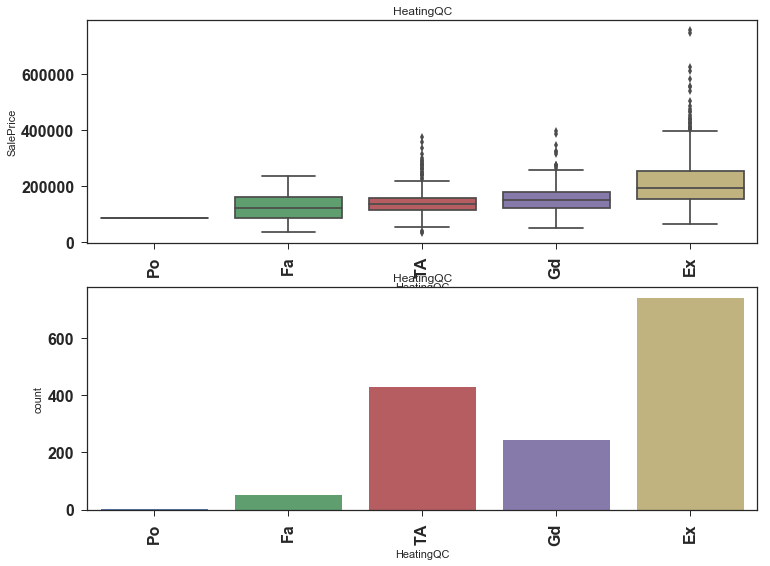

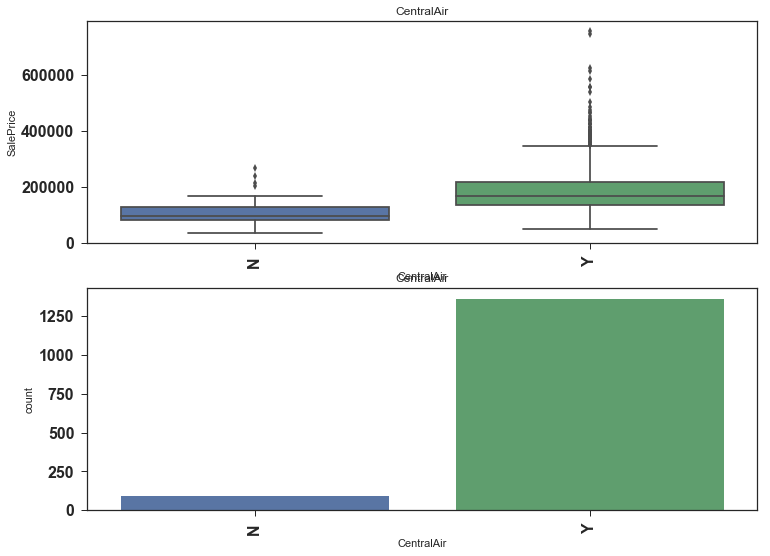

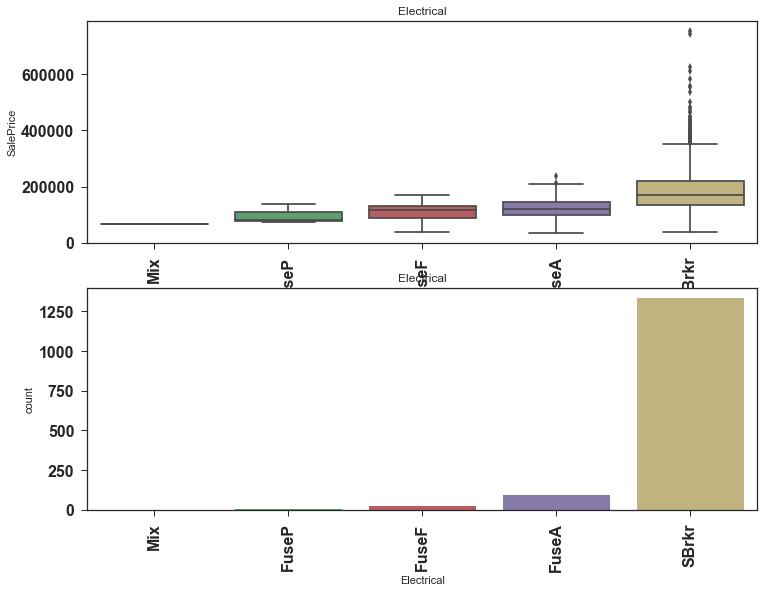

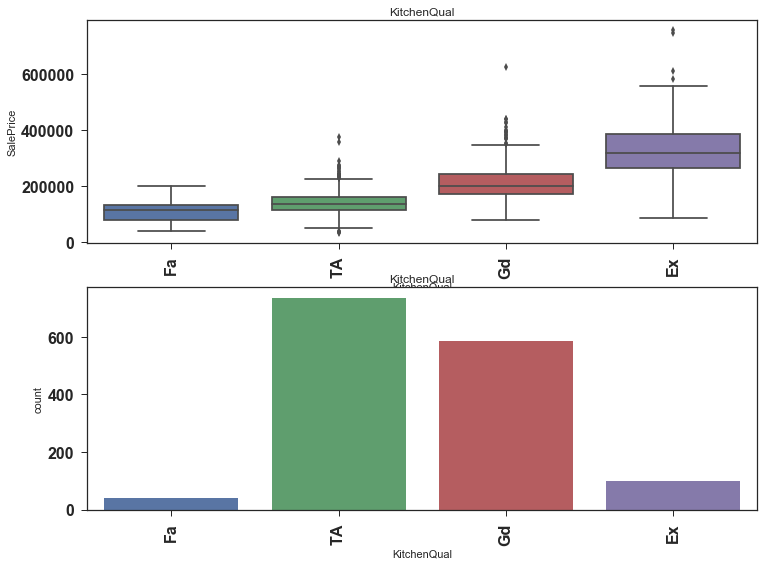

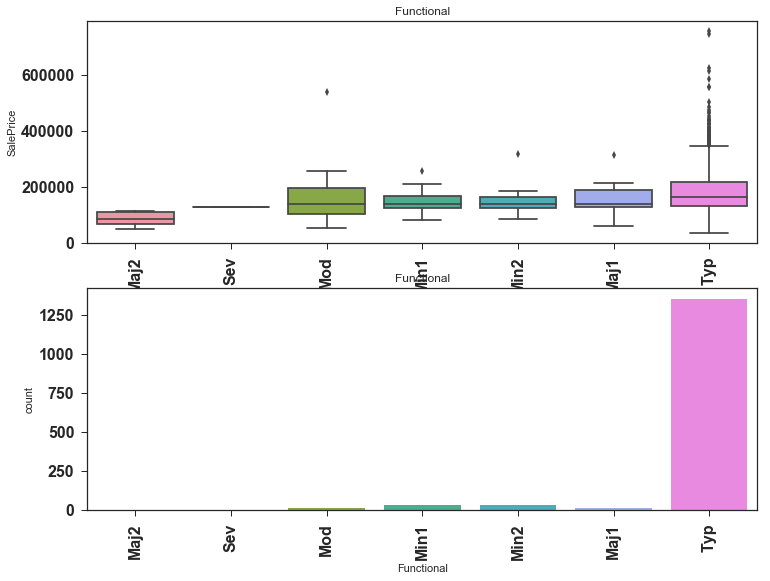

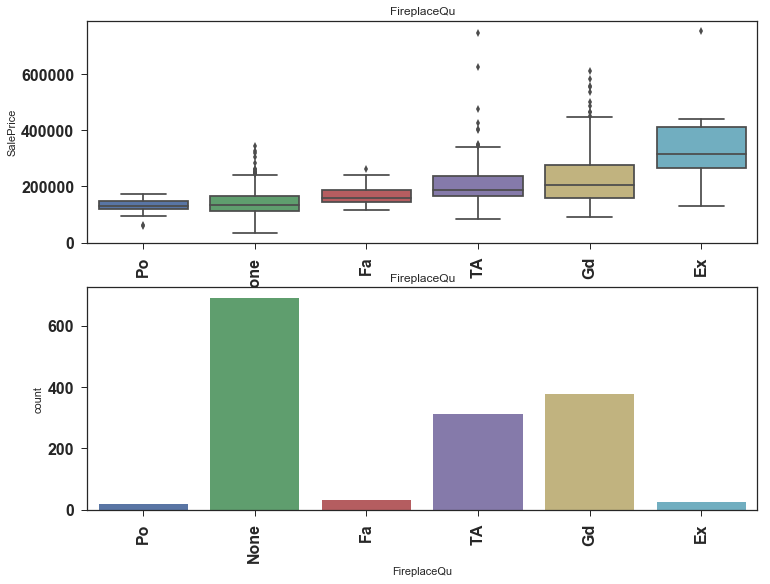

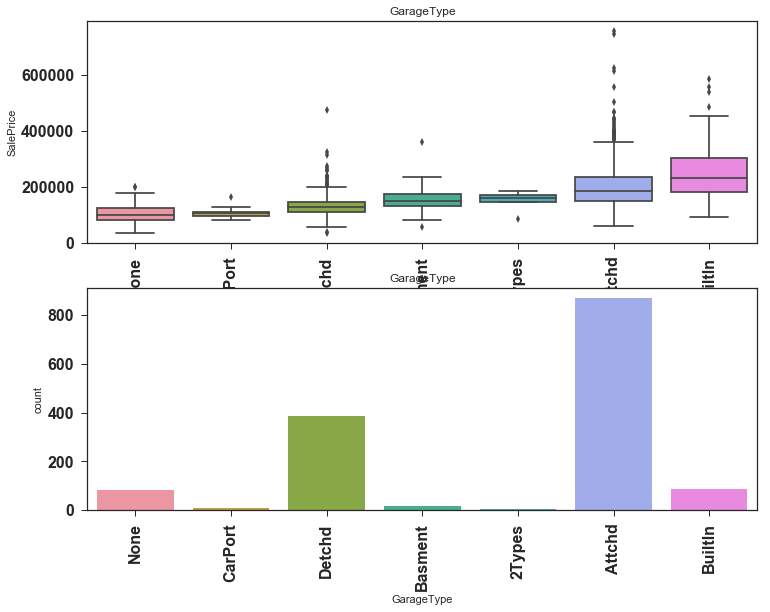

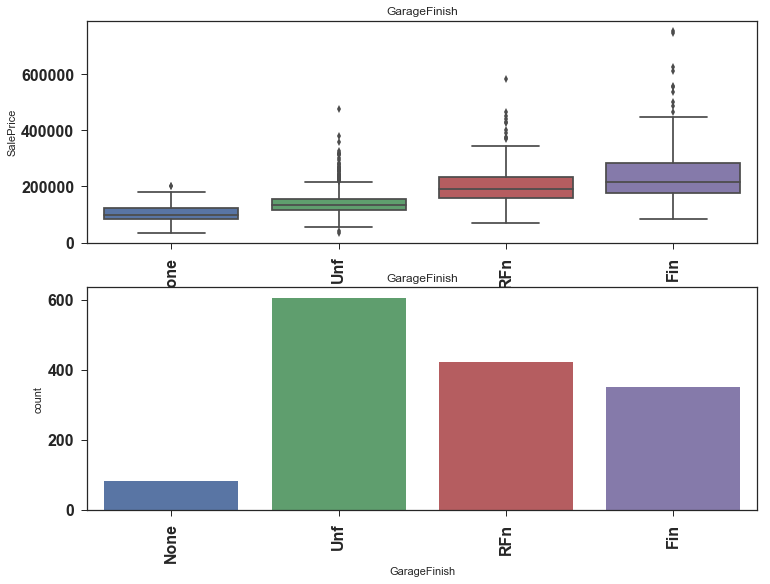

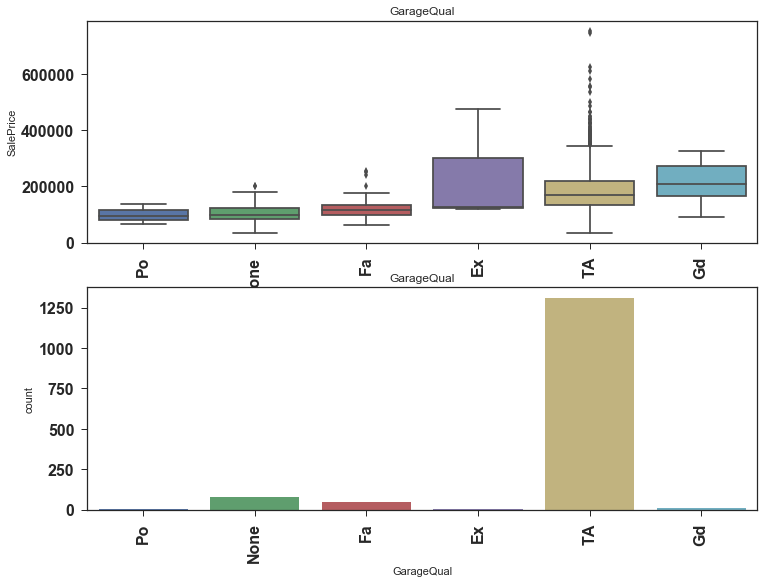

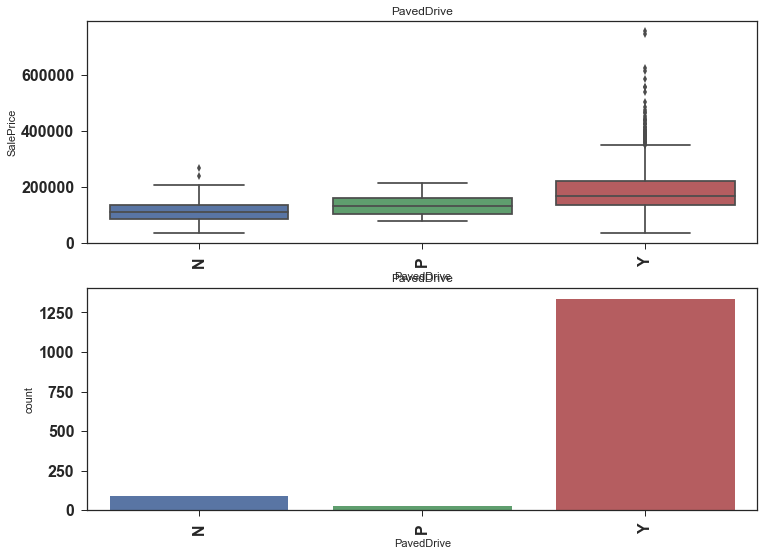

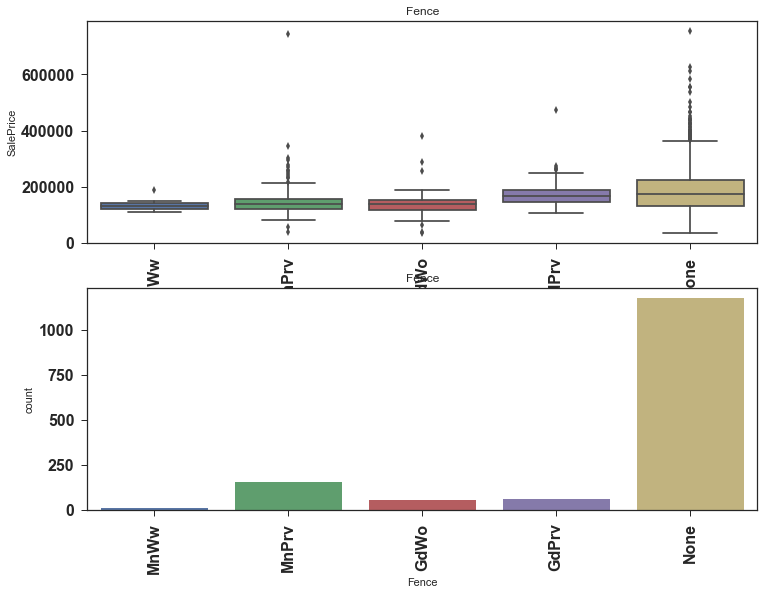

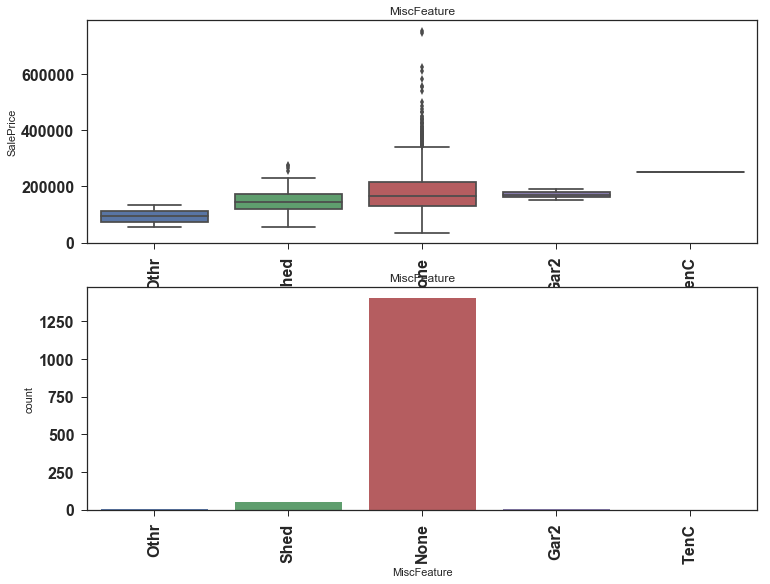

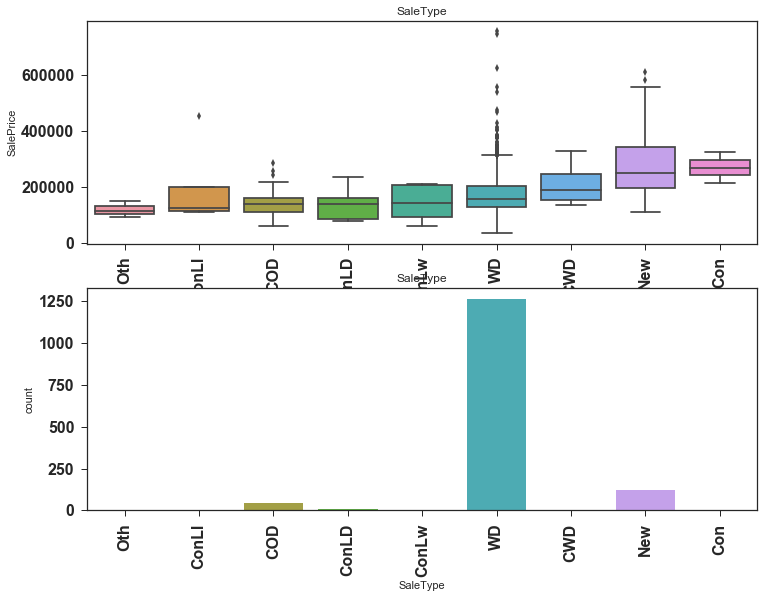

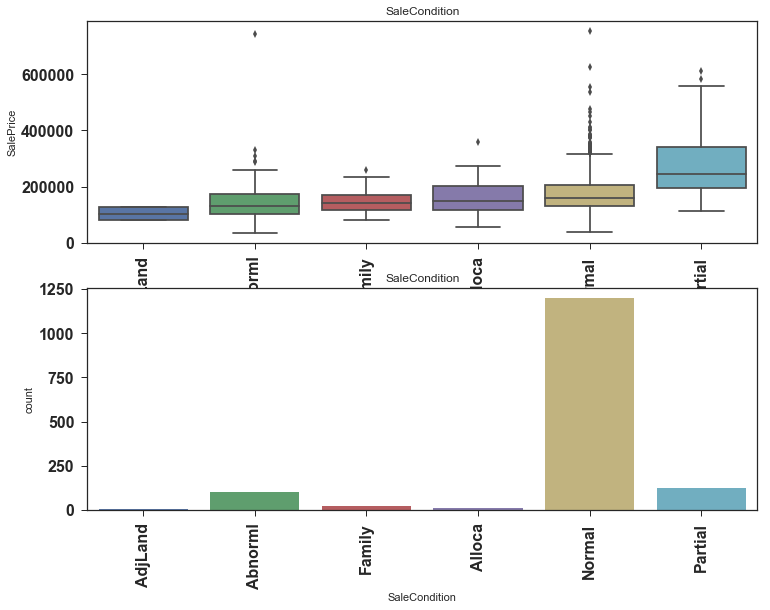

In [83]:
for category in categorical:
    medians = train['SalePrice'].groupby(train[category]).median()
    sort = medians.sort_values()
    names_sorted = list(sort.index)

    fig, (ax1,ax2) = plt.subplots(2, figsize=(12,9))
    seaborn.boxplot(category,'SalePrice', data=train,ax=ax1,order=names_sorted)
    seaborn.countplot(x=category, data=train,ax=ax2,order=names_sorted)
    for ax in fig.axes:
        plt.sca(ax)
        plt.xticks(rotation=90)
        plt.title(category)
    plt.show()



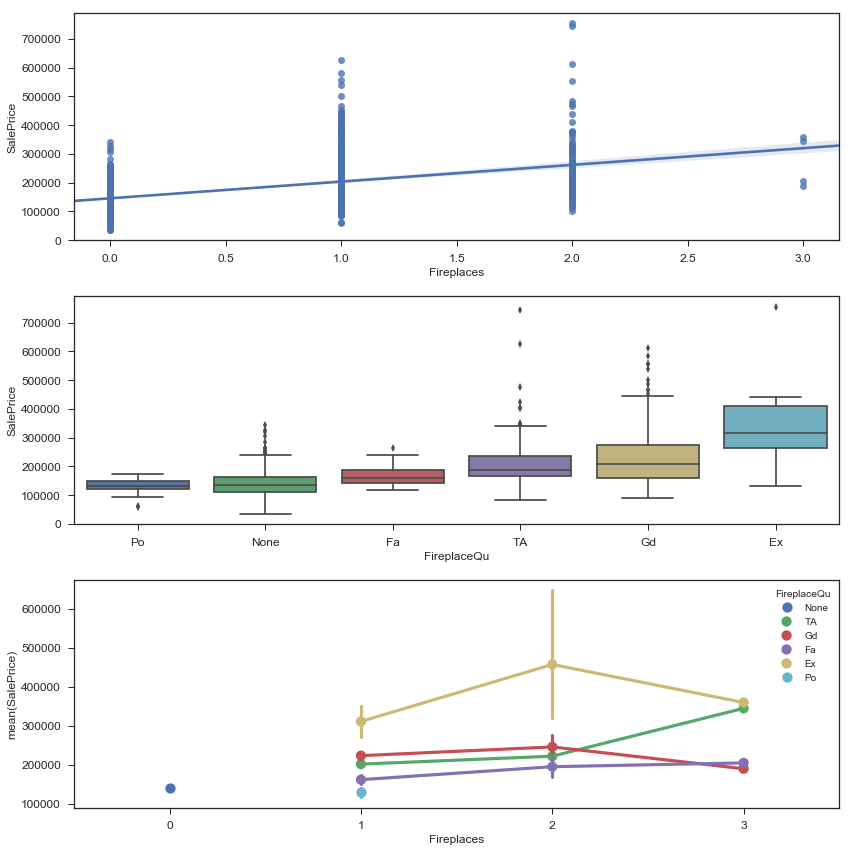

In [41]:
fig, axs = plt.subplots(nrows=3,ncols=1,figsize=(12,12))
seaborn.regplot(x='Fireplaces', y='SalePrice', data=train, ax=axs[0])
medians = train['SalePrice'].groupby(train['FireplaceQu']).median()
sort = medians.sort_values()
names_sorted = list(sort.index)
seaborn.boxplot(x='FireplaceQu', y='SalePrice', data=train, order=names_sorted,ax=axs[1])
seaborn.pointplot(x='Fireplaces',y='SalePrice',hue='FireplaceQu',data=train,ax=axs[2])


#matplotlib.rcParams['font.weight']=('bold')    # bold fonts are easier to see
#matplotlib.rcParams['ytick.labelsize']=(16)   # tick labels bigger
#matplotlib.rcParams['xtick.labelsize']=(16)   # tick labels bigger
#matplotlib.rcParams['axes.labelsize']=(24)   # tick labels bigger
plt.tight_layout()

plt.savefig('SalePrice_Fireplaces.png', dpi=320)


## Replacing categorical variables with binary features (dummies)

In [84]:
train.to_csv("new_training_data.csv")
train = pd.read_csv("new_training_data.csv")
no_dummies = train.copy()
no_dummies.to_csv("no_dummies.csv")
train = pd.get_dummies(train)


## Checking out correlation to sales price with included categorical features.

### Notice how features like RoofMatl_ClyTile have low correlation; yet, they have a huge impact on our Lasso model. This is definitely an unbalanced variable.

In [43]:
sale_correlation = train.corr()['SalePrice']
with pd.option_context('display.max_rows', None, 'display.max_columns', 1000):
    print sale_correlation[np.argsort(sale_correlation, axis=0)]

ExterQual_TA            -0.589909
KitchenQual_TA          -0.519821
FireplaceQu_None        -0.472350
BsmtQual_TA             -0.452785
GarageFinish_Unf        -0.410942
MasVnrType_None         -0.368020
GarageType_Detchd       -0.354326
Foundation_CBlock       -0.343582
HeatingQC_TA            -0.312869
MSZoning_RM             -0.288169
LotShape_Reg            -0.268191
BsmtExposure_No         -0.264150
CentralAir_N            -0.251385
SaleType_WD             -0.244083
GarageFinish_None       -0.236883
GarageQual_None         -0.236883
GarageCond_None         -0.236883
GarageType_None         -0.236883
RoofStyle_Gable         -0.225583
PavedDrive_N            -0.212682
Foundation_BrkTil       -0.204187
Electrical_FuseA        -0.194031
Neighborhood_OldTown    -0.192247
Neighborhood_NAmes      -0.188604
Neighborhood_Edwards    -0.181106
Exterior1st_MetalSd     -0.167155
Neighborhood_IDOTRR     -0.164087
HouseStyle_1.5Fin       -0.163534
Exterior2nd_MetalSd     -0.162473
Exterior2nd_Wd

In [44]:
def check_sparsity(data):
    sparseness = data[data[list(data.columns.values)]==0].count()/len(data)
    with pd.option_context('display.max_rows', None, 'display.max_columns', 1000):
        print sparseness[np.argsort(sparseness, axis=0)]
check_sparsity(train)

MoSold                   0.000000
MSSubClass               0.000000
LotFrontage              0.000000
LotArea                  0.000000
OverallQual              0.000000
OverallCond              0.000000
YearBuilt                0.000000
YearRemodAdd             0.000000
YrSold                   0.000000
SalePrice                0.000000
GarageYrBlt              0.000000
TotRmsAbvGrd             0.000000
1stFlrSF                 0.000000
GrLivArea                0.000000
KitchenAbvGr             0.000686
Utilities_AllPub         0.000686
Unnamed: 0               0.000686
BedroomAbvGr             0.004115
Street_Pave              0.004115
PoolQC_None              0.004115
FullBath                 0.006173
Condition2_Norm          0.009602
RoofMatl_CompShg         0.017147
Heating_GasA             0.021948
TotalBsmtSF              0.025377
MiscFeature_None         0.037037
LandSlope_Gtl            0.053498
GarageCars               0.055556
GarageArea               0.055556
Alley_None    

## Lets try variables with highest correlation

In [45]:
sale_correlation[np.argsort(sale_correlation, axis=0)]
highly_correlated = []
for i in range(len(sale_correlation)):
    if sale_correlation[i] > .5 or sale_correlation[i] < -.2:
        highly_correlated.append(sale_correlation.index[i])
highly_correlated
correlated_train = train[[col for col in highly_correlated]].copy()

#### Using log +1 transformation on many of the features because of high skewness

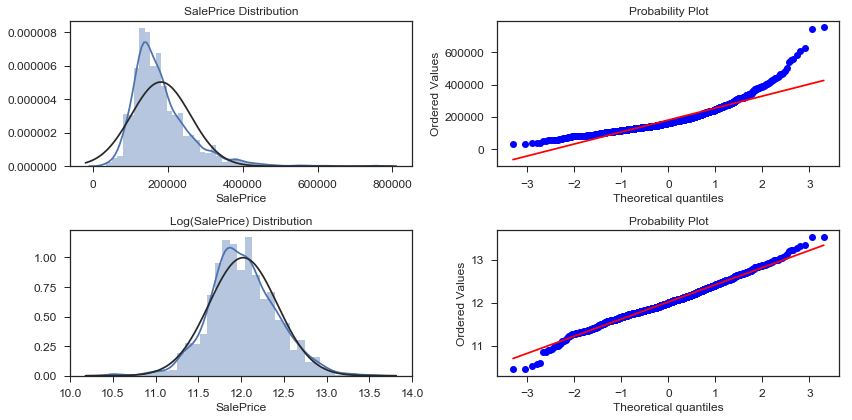

In [46]:
fig, axs = plt.subplots(2,2, figsize=(12,6))

seaborn.set_style("whitegrid")
g = seaborn.distplot(train['SalePrice'],fit=norm,ax=axs[0,0])
g.set_title("%s Distribution" % 'SalePrice')


stats.probplot(train['SalePrice'], dist='norm', plot=axs[0,1])
#axs[0,1].set_title("Normal QQ-Plot of Grade Living Area")

train['SalePrice'] = np.log1p(train['SalePrice'])

g = seaborn.distplot(train['SalePrice'],fit=norm, ax=axs[1,0])
g.set_title("Log(%s) Distribution" % 'SalePrice')

stats.probplot(train['SalePrice'], dist='norm', plot=axs[1,1])

plt.tight_layout()
plt.savefig("Sale Price Log Transformation")
plt.show()

### Ridge seems to perform as well as Lasso, with less effort computationally because it responds better to multicolinearity 

In [47]:

RMSE = CV(train,Lin_Reg,5)
print(RMSE)

RMSE = CV(train,RidgeCV_Reg,5)
print(RMSE)

RMSE = CV(train,LassoCV_Reg,5)
print(RMSE)

0.12711699373
0.113970017314


/Users/triciangoon/anaconda2/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:466: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
/Users/triciangoon/anaconda2/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


0.116711306591


In [48]:
numerical_features = [key for key in dict(no_dummies.dtypes) if dict(no_dummies.dtypes)[key] in ['float64', 'int64']]
skewed_features = []
for feature in numerical_features:
    if abs(train[feature].skew()) > .8:
        skewed_features.append(feature)
        

In [49]:
skewed_features

['3SsnPorch',
 'BsmtUnfSF',
 '2ndFlrSF',
 'LotArea',
 'GrLivArea',
 'MasVnrArea',
 'LotFrontage',
 'MiscVal',
 'KitchenAbvGr',
 'BsmtHalfBath',
 'BsmtFinSF2',
 'OpenPorchSF',
 'PoolArea',
 'ScreenPorch',
 'MSSubClass',
 'WoodDeckSF',
 '1stFlrSF',
 'LowQualFinSF',
 'EnclosedPorch']

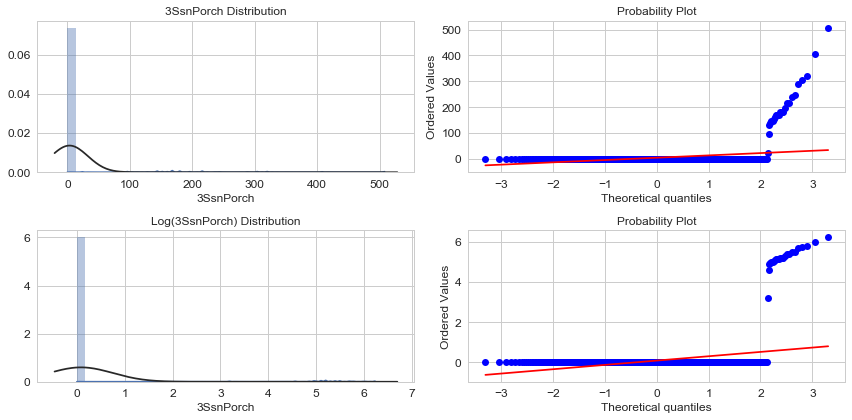

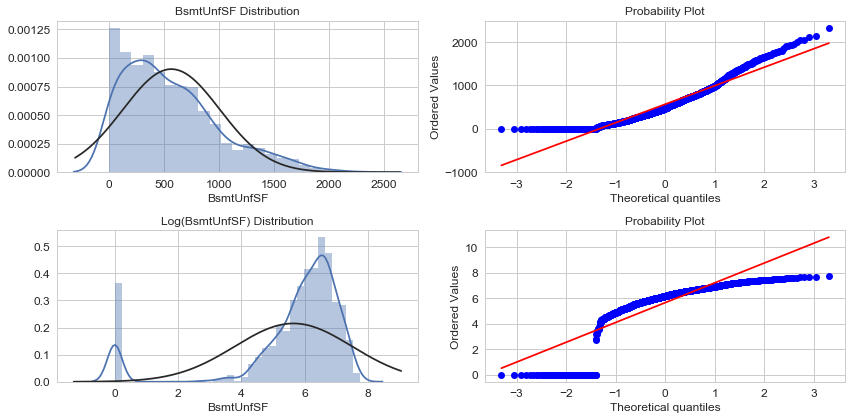

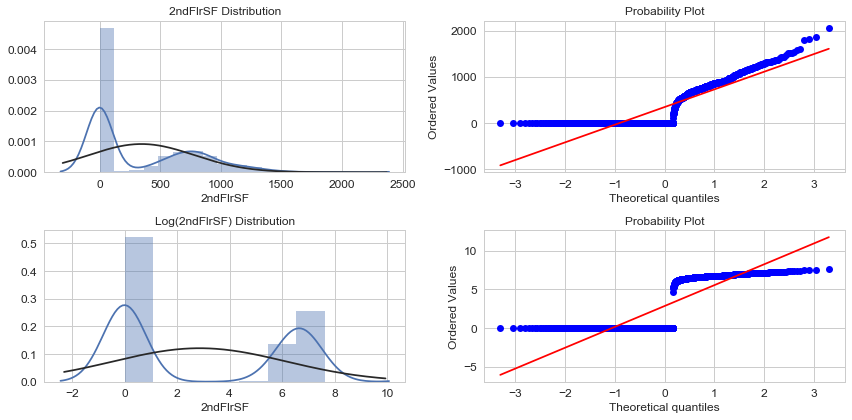

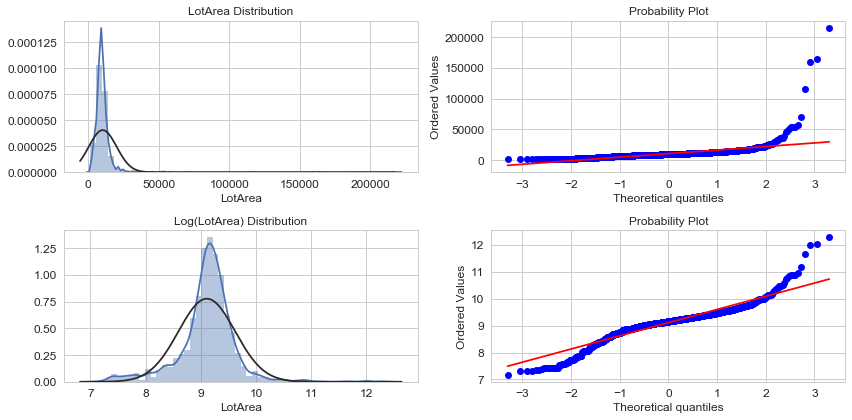

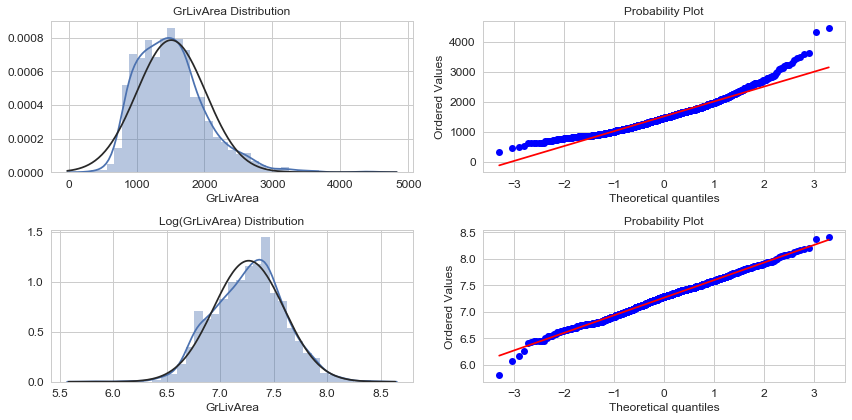

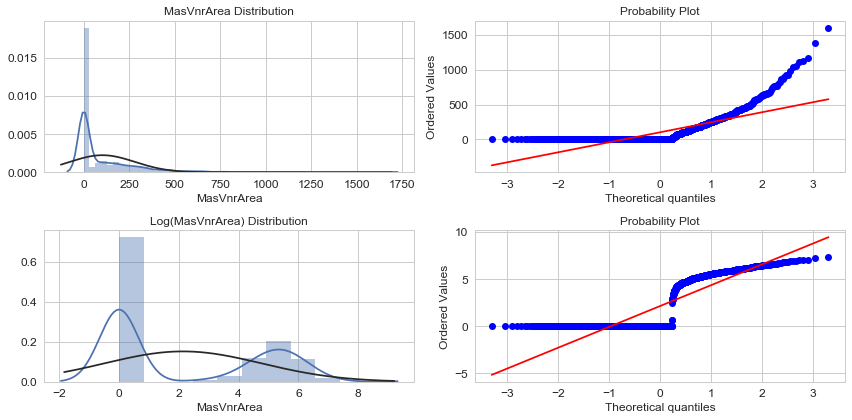

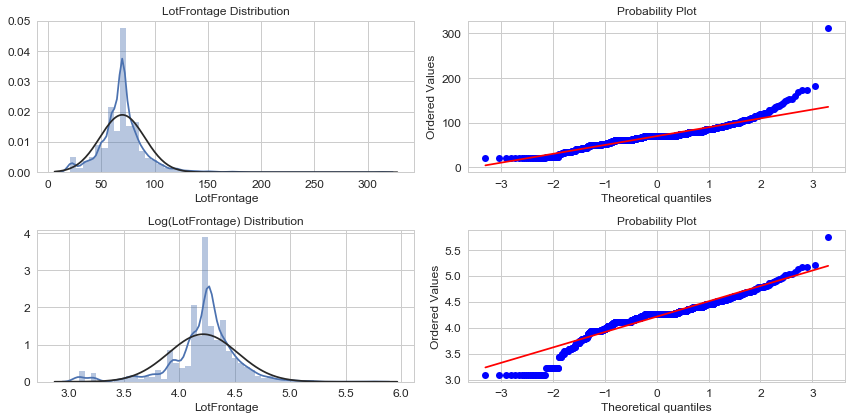

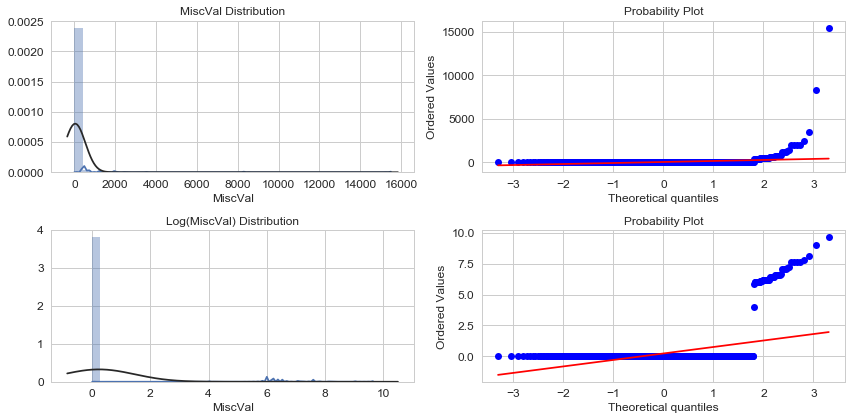

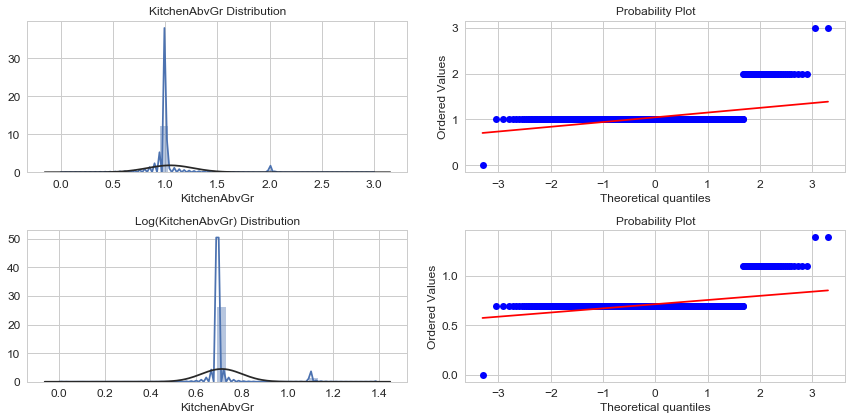

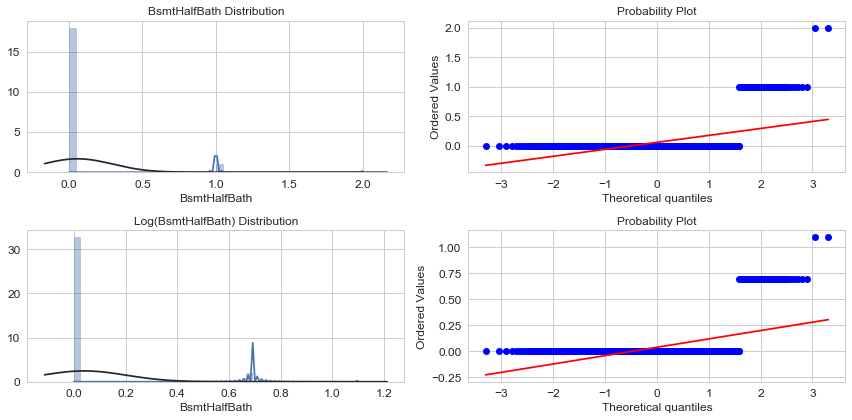

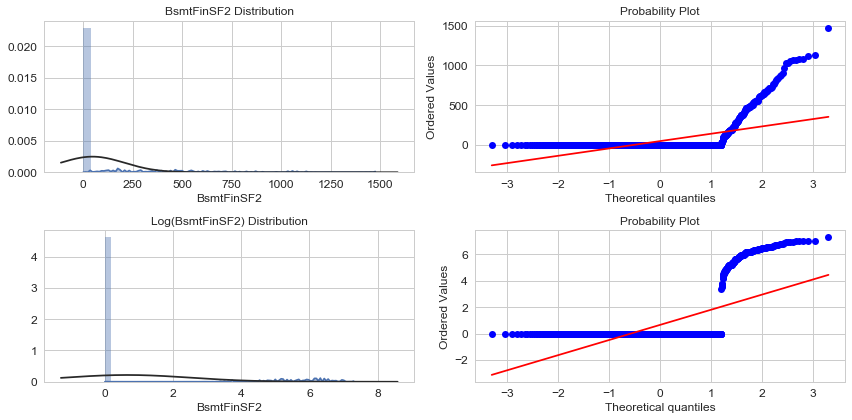

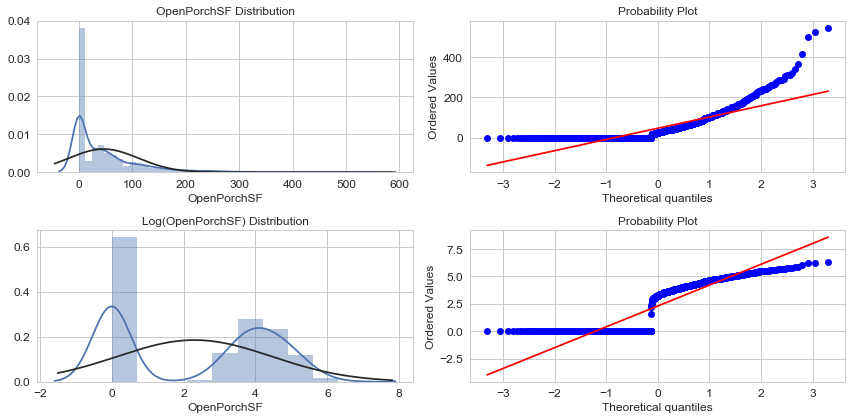

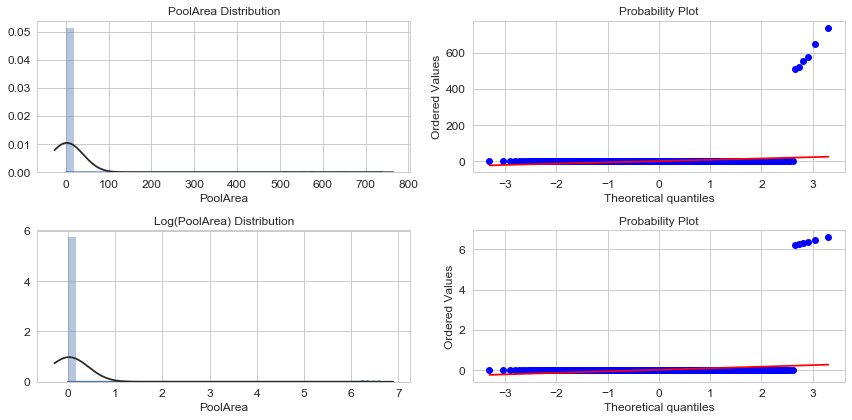

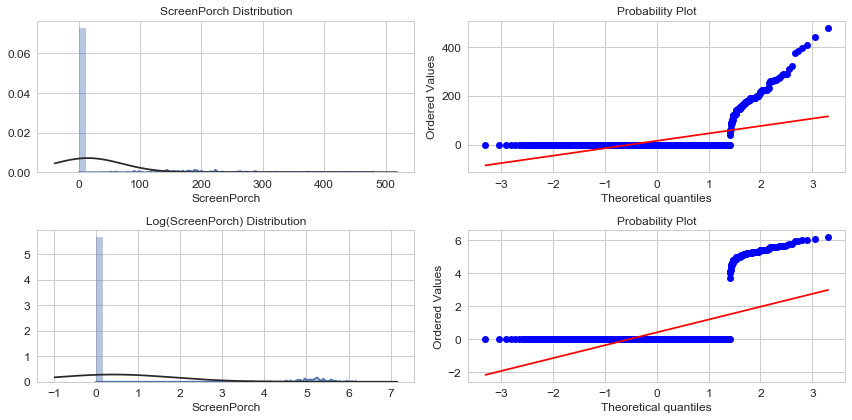

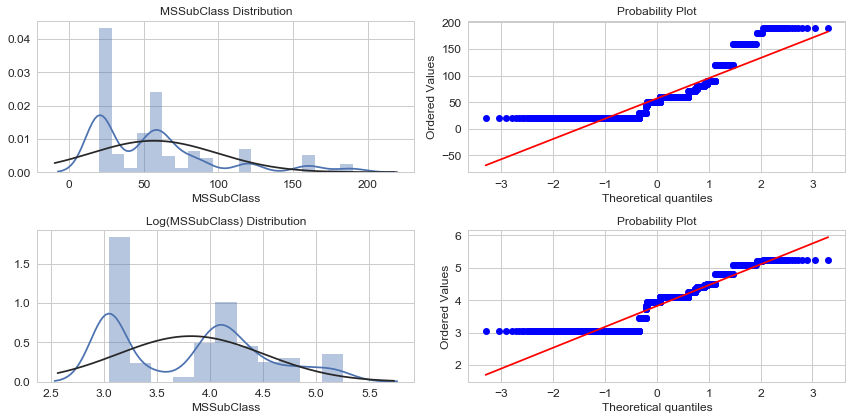

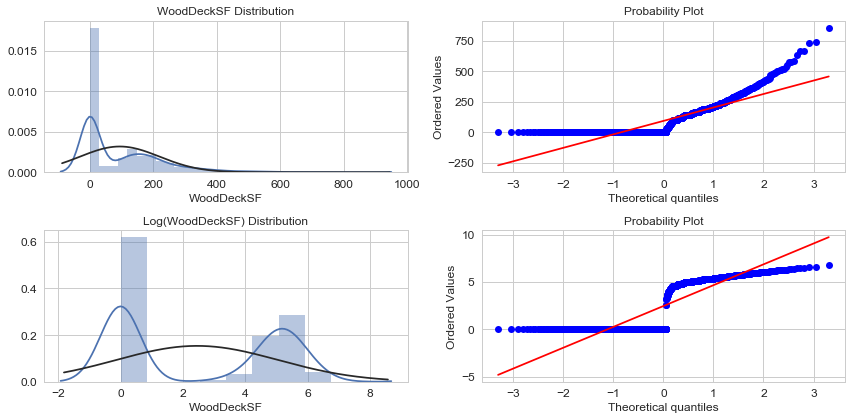

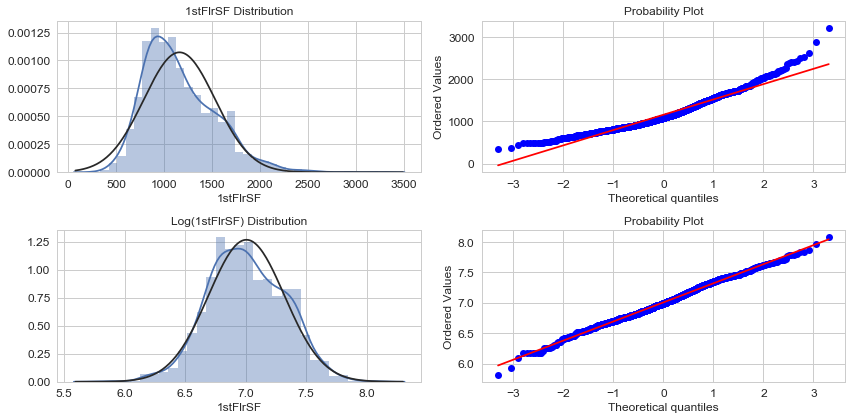

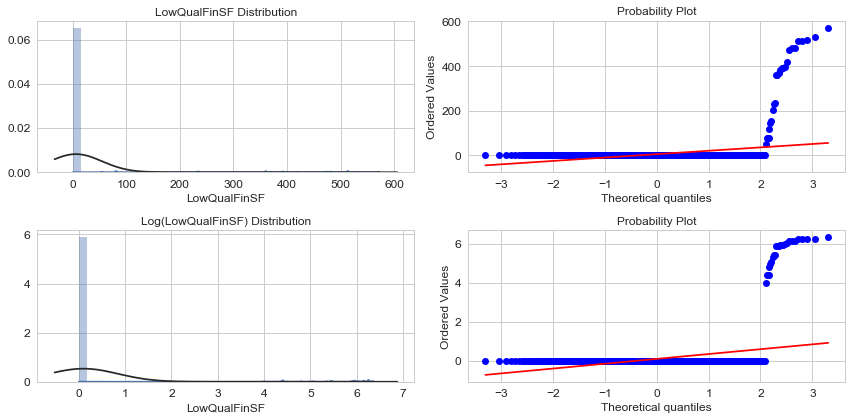

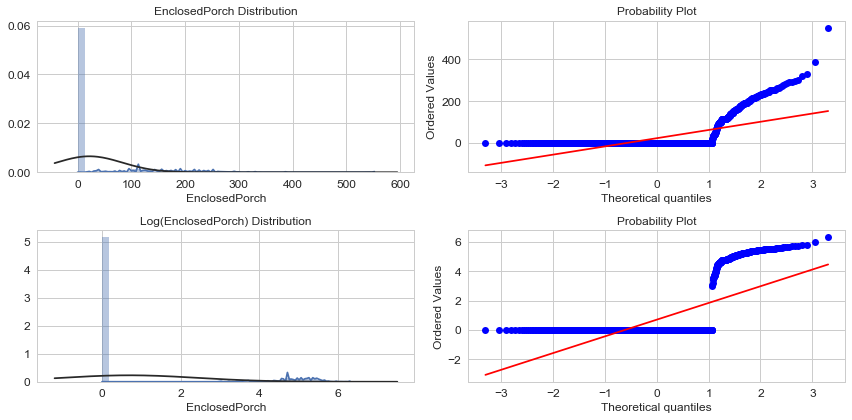

In [50]:
transformed_train = train.copy()
for feature in skewed_features:
    fig, axs = plt.subplots(2,2, figsize=(12,6))

    seaborn.set_style("whitegrid")
    g = seaborn.distplot(transformed_train[feature],fit=norm,ax=axs[0,0])
    g.set_title("%s Distribution" % feature)


    stats.probplot(transformed_train[feature], dist='norm', plot=axs[0,1])
    #axs[0,1].set_title("Normal QQ-Plot of Grade Living Area")

    transformed_train[feature] = np.log1p(transformed_train[feature])

    g = seaborn.distplot(transformed_train[feature],fit=norm, ax=axs[1,0])
    g.set_title("Log(%s) Distribution" % feature)

    stats.probplot(transformed_train[feature], dist='norm', plot=axs[1,1])
    
    plt.tight_layout()
    plt.show()

In [51]:
print(CV(train,Lin_Reg,5))


print(CV(train,RidgeCV_Reg,5))


print(CV(train,LassoCV_Reg,5))

    

0.128514796026
0.114292001817
0.114133474905


#### Many of our variables had a large portion of their values as 0, and a log1p transformation will not affect those much
    Through cross validation, I found that log transforming all the skewed variables yielded better results.

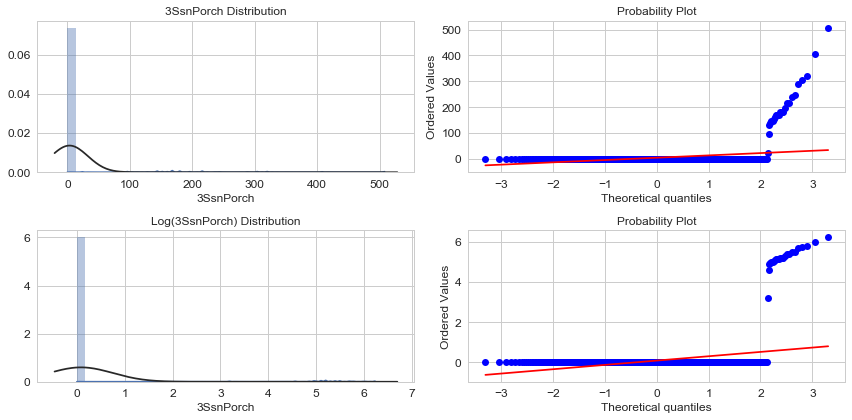

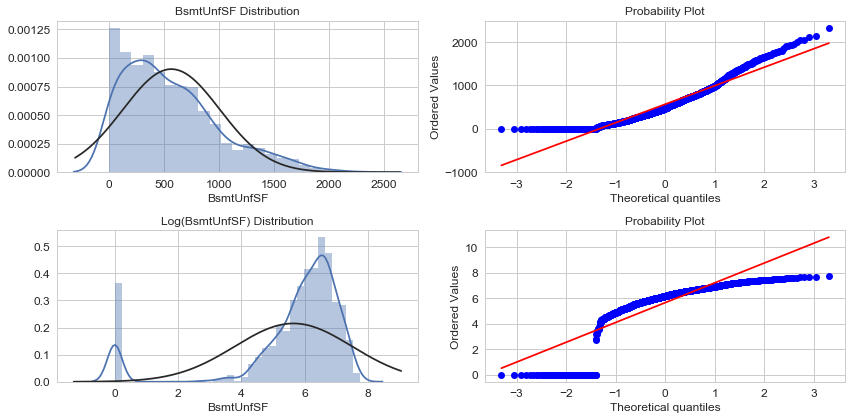

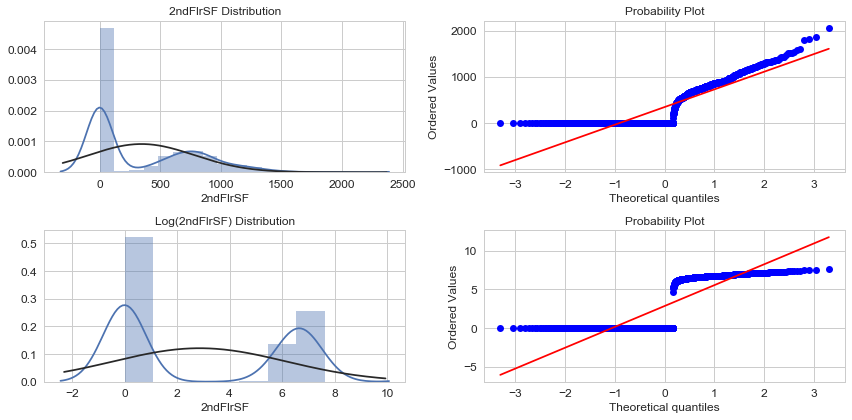

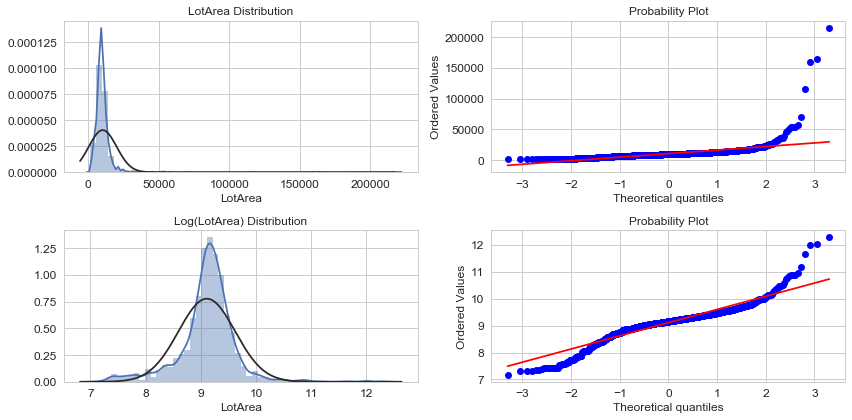

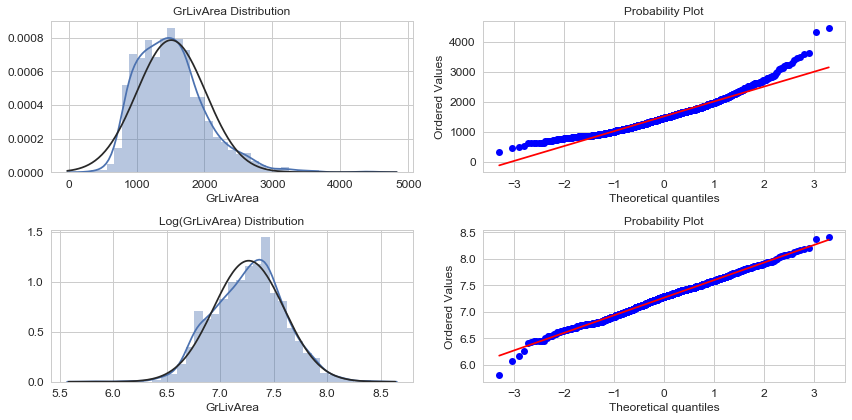

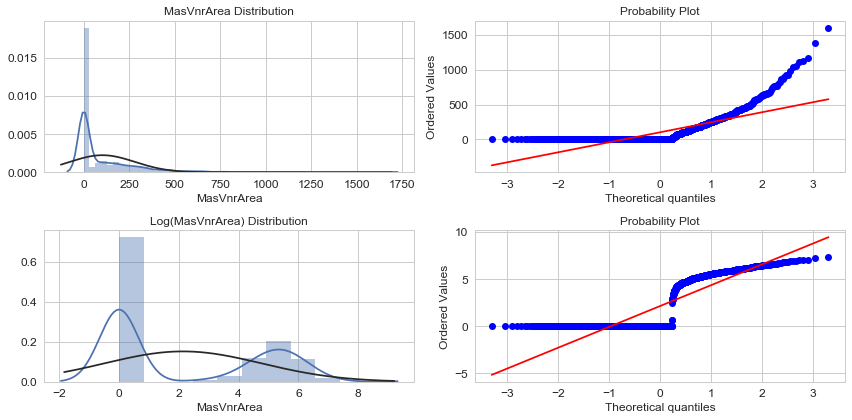

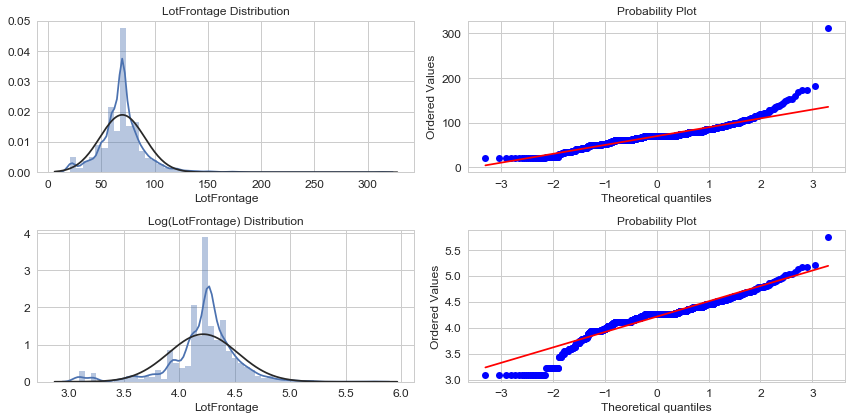

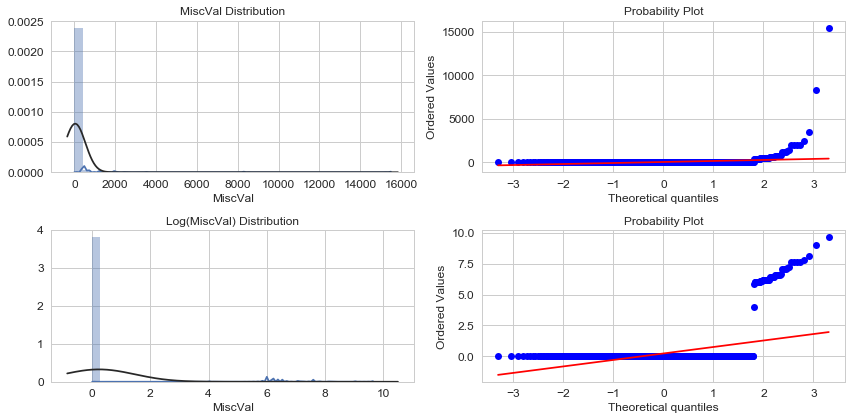

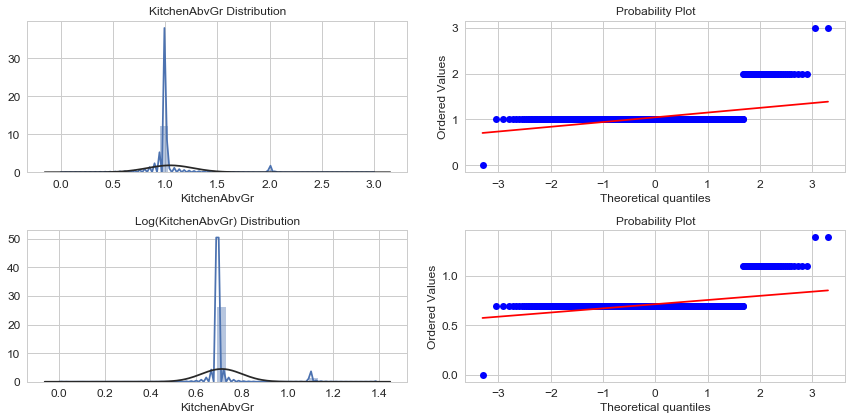

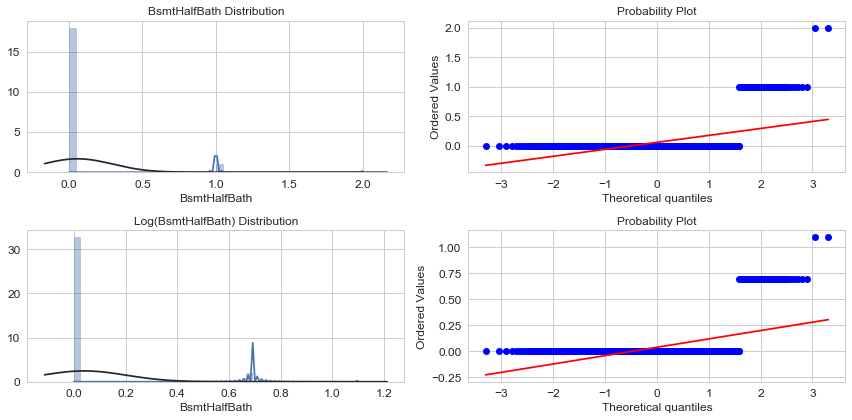

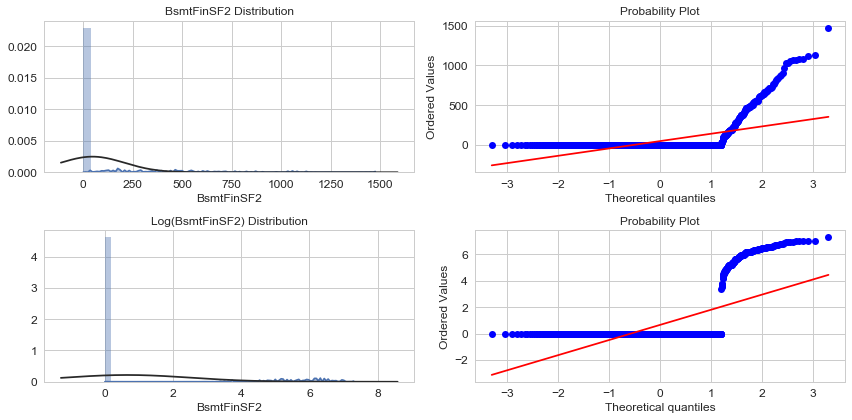

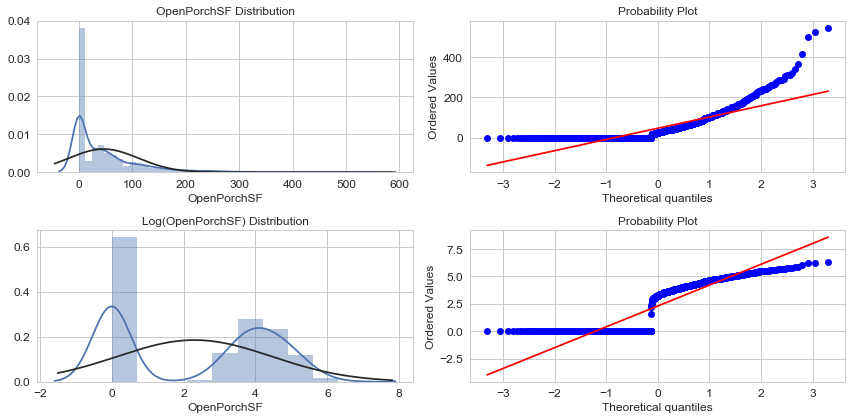

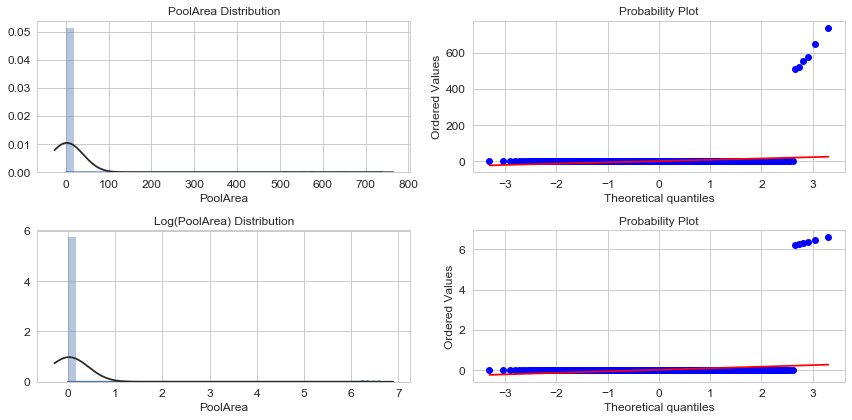

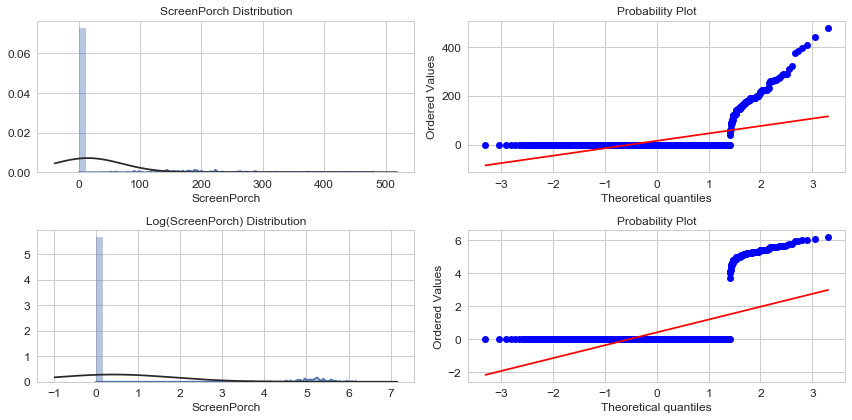

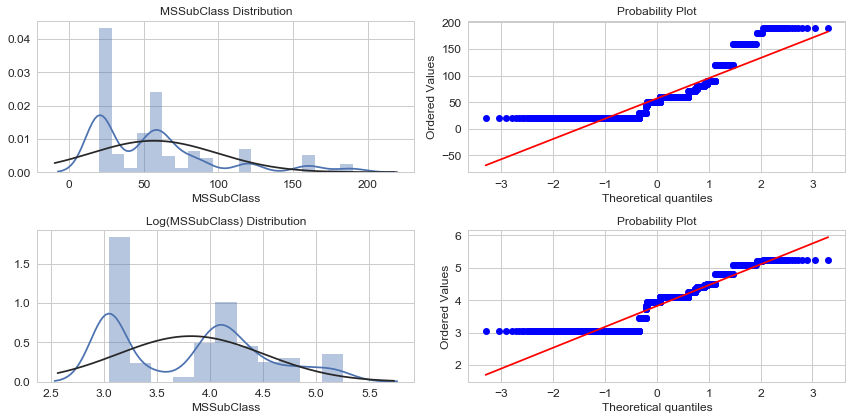

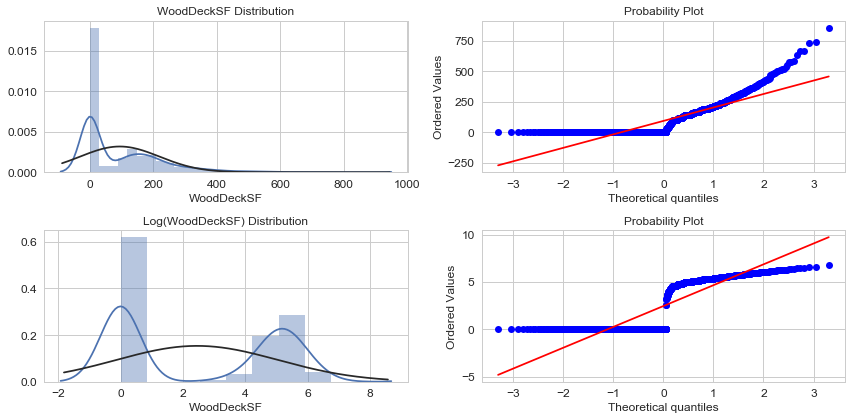

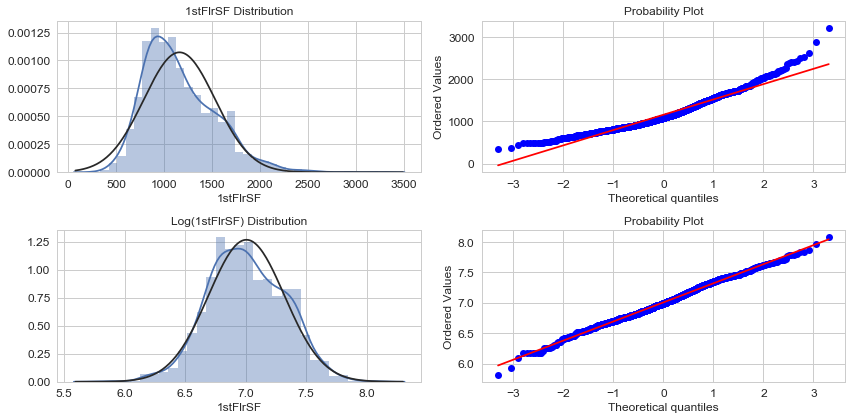

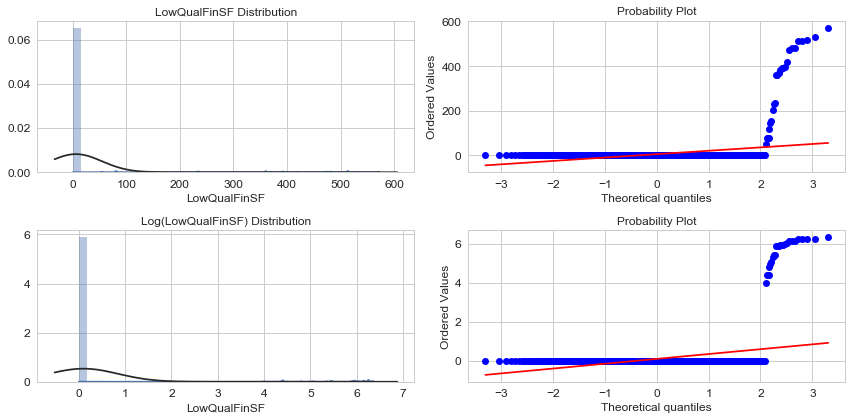

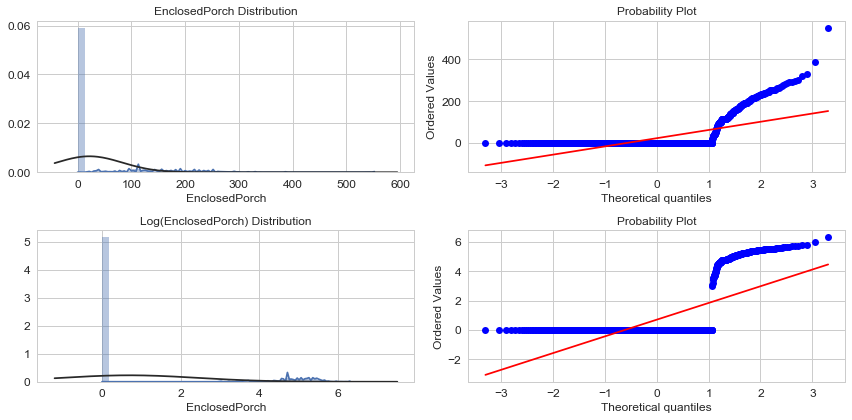

In [52]:
good_transformations = ['LotArea','GrLivArea','MSSubClass','1stFlrSF']

for feature in skewed_features:
    fig, axs = plt.subplots(2,2, figsize=(12,6))

    seaborn.set_style("whitegrid")
    g = seaborn.distplot(train[feature],fit=norm,ax=axs[0,0])
    g.set_title("%s Distribution" % feature)


    stats.probplot(train[feature], dist='norm', plot=axs[0,1])
    #axs[0,1].set_title("Normal QQ-Plot of Grade Living Area")

    train[feature] = np.log1p(train[feature])

    g = seaborn.distplot(train[feature],fit=norm, ax=axs[1,0])
    g.set_title("Log(%s) Distribution" % feature)

    stats.probplot(train[feature], dist='norm', plot=axs[1,1])
    
    plt.tight_layout()
    #plt.savefig("Log Transformation_%s" % feature)
    plt.show()

In [53]:

print(CV(train,Lin_Reg,5))


print(CV(train,RidgeCV_Reg,5))


print(CV(train,LassoCV_Reg,5))

    

0.131592818426
0.112775984223
0.112059504467


## The coefficients in Lasso are not interpretable because of multicolinearity. Features with high correlation are chosen arbitrarily based on alpha

Eliminated: 184. Used: 118


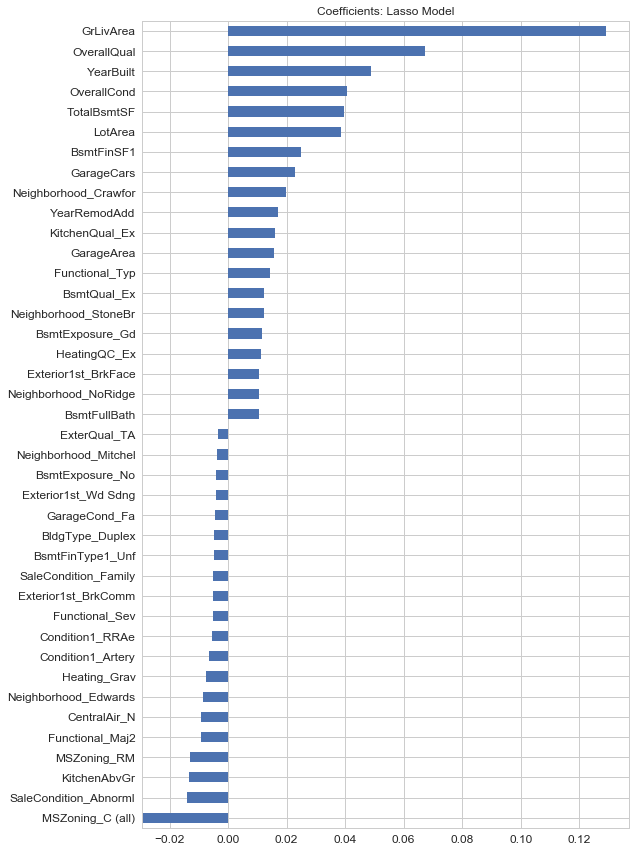

In [54]:
X = train.copy()

y = X.SalePrice
X = pd.DataFrame(preprocessing.scale(X), index = X.index, columns = X.columns) 
del X['SalePrice']
LassoCV_Reg.fit(X,y)
Lasso_Coefficients = pd.Series(LassoCV_Reg.coef_, index = X.columns)
print("Eliminated: " + str(sum(Lasso_Coefficients == 0)) + ". Used: " +  str(sum(Lasso_Coefficients != 0)))
Sorted_Coefficients = Lasso_Coefficients.sort_values()
HighLow_Coefficients = pd.concat([Sorted_Coefficients.head(20),Sorted_Coefficients.tail(20)])

    
HighLow_Coefficients.plot(kind = "barh")
fig = plt.gcf()

fig.set_size_inches(9, 12)
plt.title("Coefficients: Lasso Model")
plt.tight_layout()
plt.savefig('Lasso_Normalized_Coefficients.png', dpi=320)


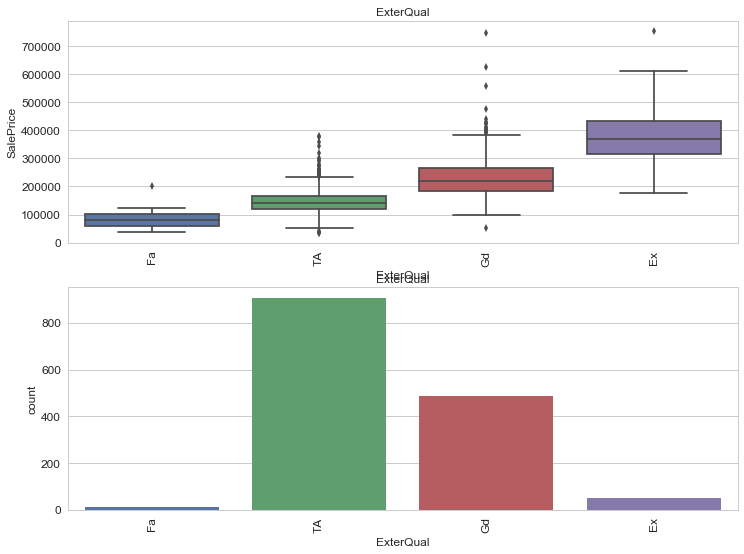

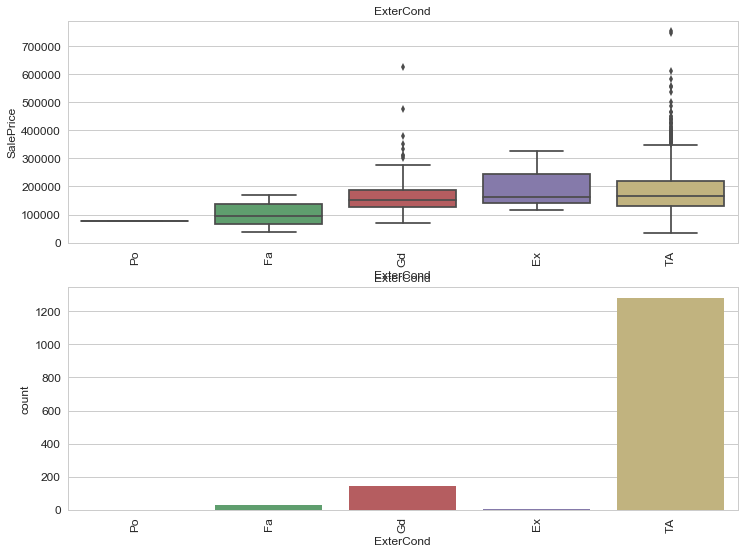

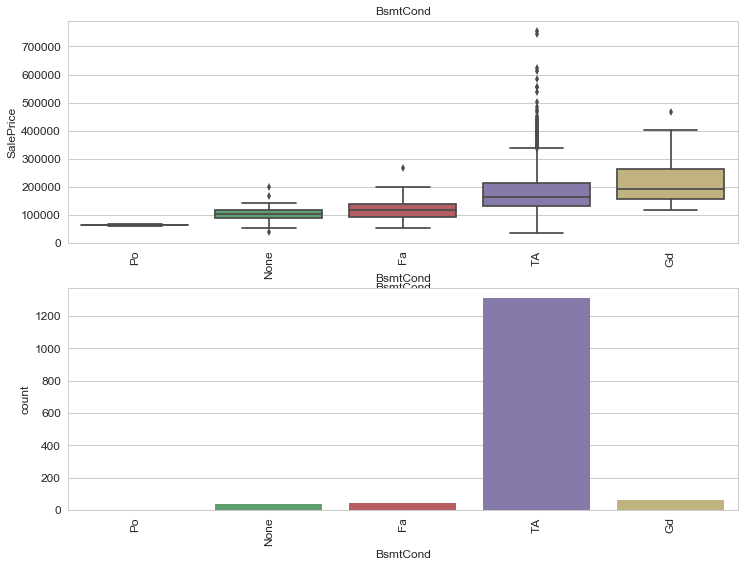

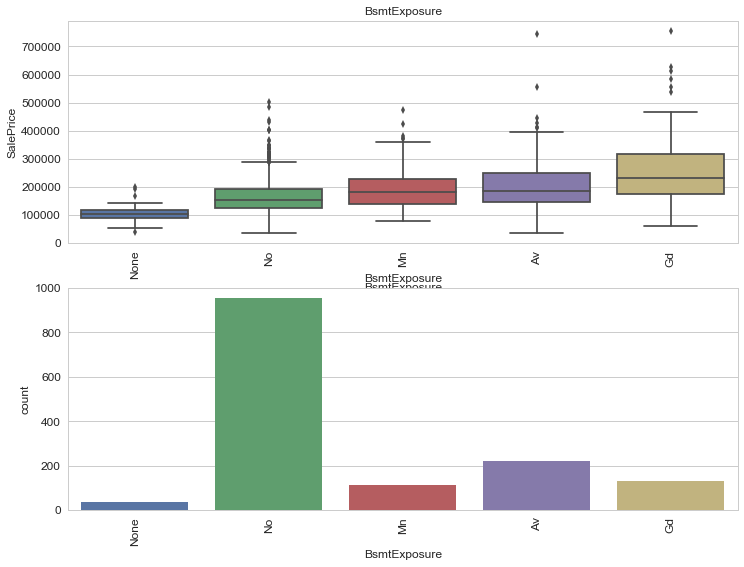

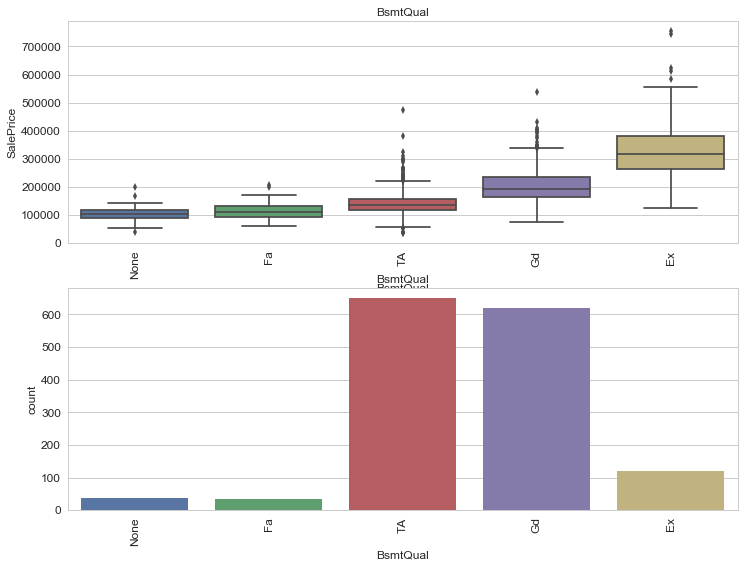

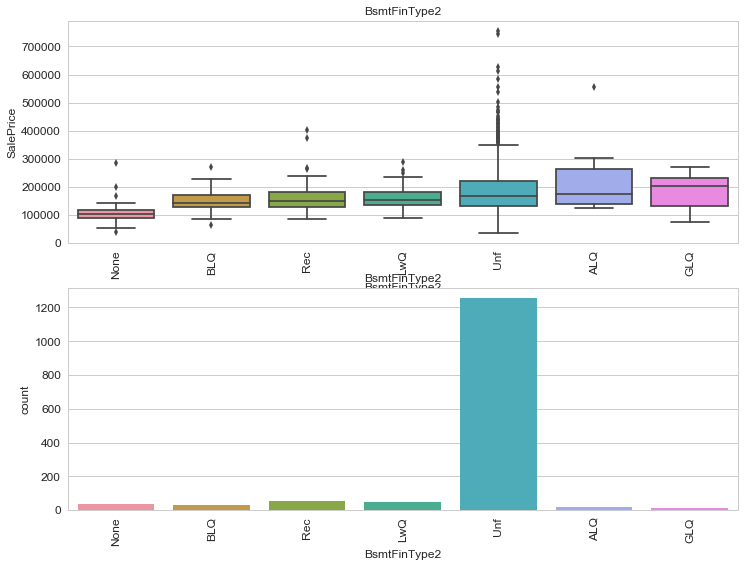

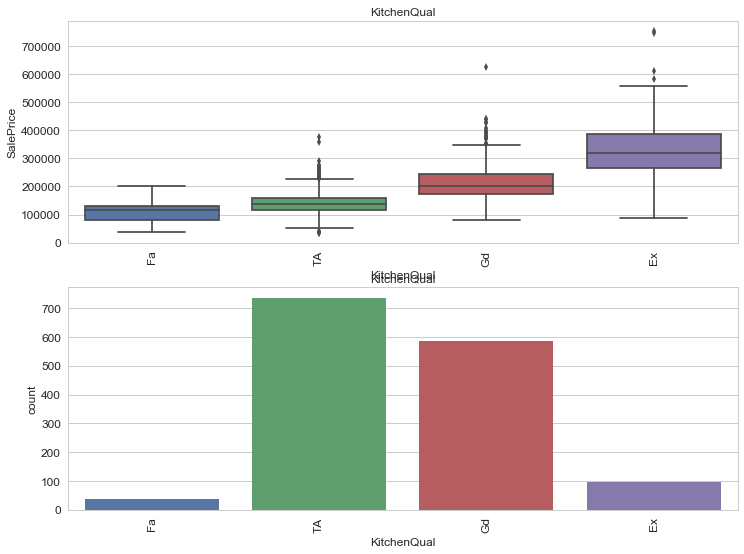

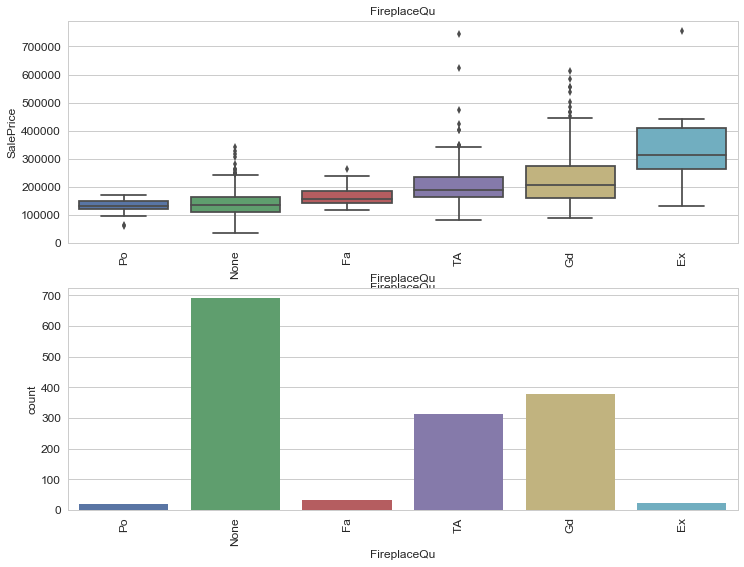

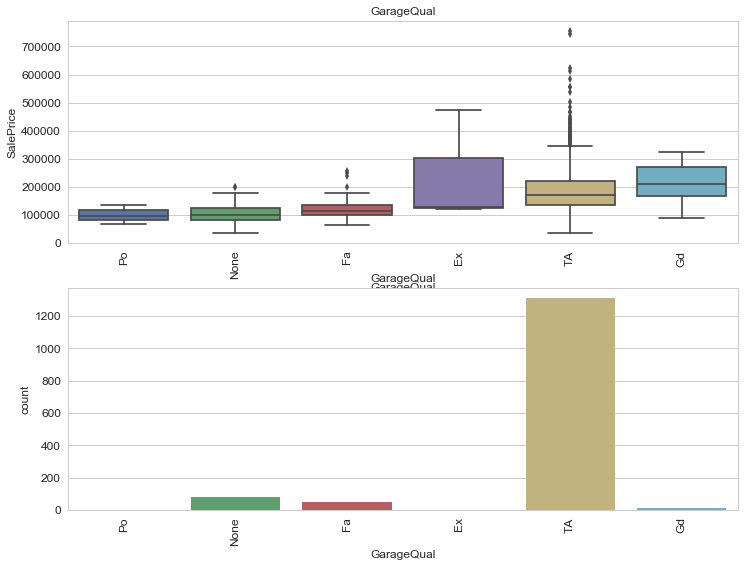

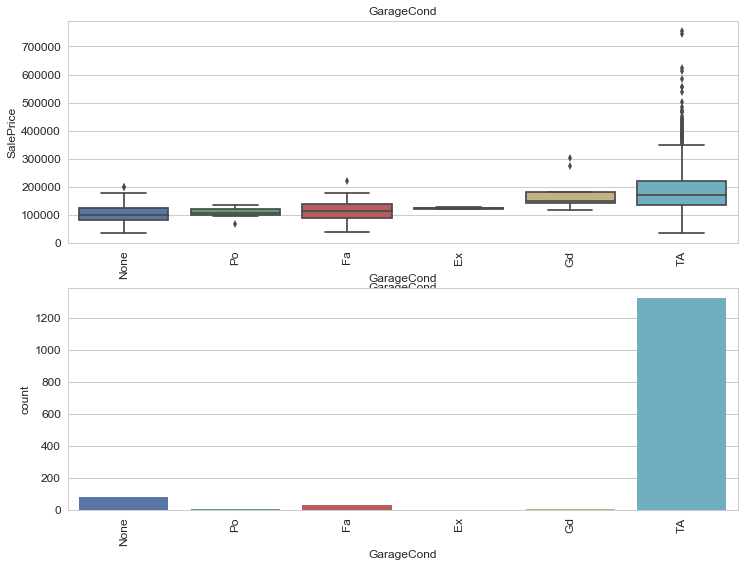

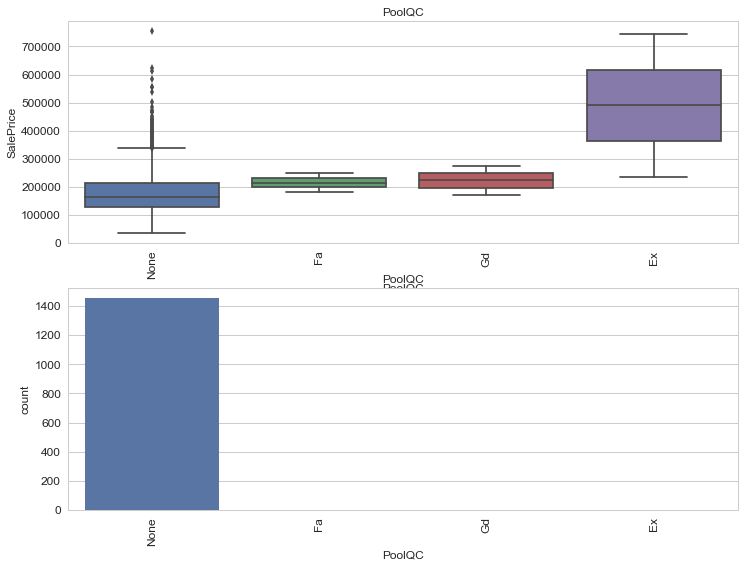

In [55]:
ord_cat = ['ExterQual','ExterCond','BsmtCond','BsmtExposure','BsmtQual','BsmtFinType2','KitchenQual','FireplaceQu','GarageQual','GarageCond',
          'PoolQC']

for category in ord_cat:
    medians = no_dummies['SalePrice'].groupby(no_dummies[category]).median()
    sort = medians.sort_values()
    names_sorted = list(sort.index)

    fig, (ax1,ax2) = plt.subplots(2, figsize=(12,9))
    seaborn.boxplot(category,'SalePrice', data=no_dummies,ax=ax1,order=names_sorted)
    seaborn.countplot(x=category, data=no_dummies,ax=ax2,order=names_sorted)
    for ax in fig.axes:
        plt.sca(ax)
        plt.xticks(rotation=90)
        plt.title(category)
    plt.show()



In [56]:
RMSE = CV(train,Lin_Reg,5)
print(RMSE)

RMSE = CV(train,RidgeCV_Reg,5)
print(RMSE)

RMSE = CV(train,LassoCV_Reg,5)
print(RMSE)
    


0.129323347304
0.111977382283
0.112986834788


In [57]:
Ridge_RMSE = []
for i in range(1):
    Ridge_RMSE.append(CV(train,RidgeCV_Reg,len(train)))
np.mean(Ridge_RMSE)

0.077316532918506889

In [58]:
Linear_RMSE = []
for i in range(1):
    Linear_RMSE.append(CV(train,Lin_Reg,len(train)))
np.mean(Linear_RMSE)

0.082708710270669603

In [59]:
Lasso_RMSE = []
LassoCV_Reg = LassoCV(alphas = [ .001*i for i in range(1000)])

for i in range(1):
    Lasso_RMSE.append(CV(train,LassoCV_Reg,100))
np.mean(Lasso_RMSE)

0.10608971464507924

### Final result for RMS Log Error if using "leave-one-out":
    Ridge : 0.077
    Lasso : Computer was going to catch fire :[. 0.104 with k=100 folds though
    Linear: 0.082
### Using k=5 folds
    Ridge: .112
    Lasso: .111
    Linear:.132


In [60]:
X = train.copy()
y = X.SalePrice

del X['SalePrice']
X = X.values

regressors.plots.plot_residuals(Lin_Reg,X,y,r_type='standardized',figsize=(12,6))


NameError: name 'regressors' is not defined

In [ ]:
regressors.plots.plot_qq(Lin_Reg, X, y,figsize=(12,6))


In [ ]:
train.to_csv("Final_Data.csv")

In [ ]:
X = train.copy()
y = X.SalePrice
del X['SalePrice']

X = X.values

LinearFitStats = Lin_Reg.fit(X,y)

In [ ]:
LinearFitStats.summary()

In [ ]:
test = pd.read_csv('Final_Data.csv')

In [ ]:
test